## 导入依赖

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [5]:
import sys
sys.path.append(r"/home/zhanglf/library")
from astropy.units import Mpc,m,s
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
sys.path.append(r"/home/zhanglf/library/Pylians3-master/")
import MAS_library as MASL
import smoothing_library as SL
import Pk_library as PKL
import seaborn as sns
sys.path.append(r"/home/zhanglf/library/myPythonLibrary")
import numpy_calculation as npc
import MatplotlibPlot as myMatplotlibPlot
PlotParams = myMatplotlibPlot.MyParams() 
import file_edit
import figure_edit
import logging
import traceback
import nbodykit.algorithms
import nbodykit.lab
import matplotlib.colors
import pynbody
import numba
import subprocess
import scipy.stats
import struct
import gc
import os

In [6]:
import resource

def limit_memory(maxsize):
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (maxsize, hard))

limit_memory(450 * 1024 * 1024 * 1024)

## 读取数据

#### displacement.py.ReadGadget() 调试文件

In [92]:
def _ReadBlock(file):
    head = file.read(4)
    if len(head) == 0:
        return None
    nBytes = struct.unpack('i', head)[0]
    buffer = file.read(nBytes)
    
    check = file.read(4)
    nBytesCheck = struct.unpack('i', check)[0]
    if (nBytes != nBytesCheck):
        print(nBytes, nBytesCheck)
        raise ValueError("invalid check length")

    return buffer

def _ReadSnapHeader(file):
    binary = _ReadBlock(file)
    if binary == None:
        raise ValueError("no bytes can be read")
    header = struct.unpack('6I6d2d2i6i2i4d2i6ii60s', binary) # 96s are unused 96 bytes
    
    dict = {}
    dict, header = _tupleUnpack(header, 6, dict, "Npart")
    dict, header = _tupleUnpack(header, 6, dict, "Massarr")
    dict, header = _tupleUnpack(header, 1, dict, "Time")
    dict, header = _tupleUnpack(header, 1, dict, "Redshift")
    dict, header = _tupleUnpack(header, 1, dict, "FlagSfr")
    dict, header = _tupleUnpack(header, 1, dict, "FlagFeedback")
    dict, header = _tupleUnpack(header, 6, dict, "Nall")
    dict, header = _tupleUnpack(header, 1, dict, "FlagCooling")
    dict, header = _tupleUnpack(header, 1, dict, "NumFiles")
    dict, header = _tupleUnpack(header, 1, dict, "BoxSize")
    dict, header = _tupleUnpack(header, 1, dict, "Omega0")
    dict, header = _tupleUnpack(header, 1, dict, "OmegaLambda")
    dict, header = _tupleUnpack(header, 1, dict, "HubbleParam")
    dict, header = _tupleUnpack(header, 1, dict, "FlagAge")
    dict, header = _tupleUnpack(header, 1, dict, "FlagMetals")
    dict, header = _tupleUnpack(header, 6, dict, "NallHW")
    dict = _tupleUnpack(header, 1, dict, "flag_entr_ics")[0]
    #----------------------------------------------------#
    # If last 60 Bytes are used, add more elements here 
    #----------------------------------------------------#
    return dict

def _ReadGroupHeader(file):
    binary = _ReadBlock(file)
    if binary == None:
        raise ValueError("no bytes can be read")
    header = struct.unpack('6qi3d', binary) # 80 Bytes in total
    
    dict = {}
    dict, header = _tupleUnpack(header, 1, dict, "Ngroups")
    dict, header = _tupleUnpack(header, 1, dict, "Nsubhalos")
    dict, header = _tupleUnpack(header, 1, dict, "Nids")
    dict, header = _tupleUnpack(header, 1, dict, "NgroupsTot")
    dict, header = _tupleUnpack(header, 1, dict, "NsubhalosTot")
    dict, header = _tupleUnpack(header, 1, dict, "NidsTot")
    dict, header = _tupleUnpack(header, 1, dict, "NumFiles")
    dict, header = _tupleUnpack(header, 1, dict, "Time / a")
    dict, header = _tupleUnpack(header, 1, dict, "Redshift")
    dict = _tupleUnpack(header, 1, dict, "BoxSize")[0]
    return dict

def _ReadSnapBody(file, FlagPtype, FlagMass, s:dict, target):
    print("Reading item", target)
    s, endFlag = _BodyBinaryUnpack2(s, file, FlagPtype, FlagMass, target=target)
    if endFlag == 1:
        print("Reach the end of the file")
    return s

def _ReadGroupBody(file, s:dict, target):
    # target should be "GroupLen", "GroupMass", "GroupPos", "GroupVel", "GroupID"
    print("Reading item", target)
    s, endFlag = _GroupBinaryUnpack(s, file, target=target)
    if endFlag == 1:
        print("Reach the end of the file")
    return s

def _tupleUnpack(tuple:tuple, size:int, dict:dict, key=''):
    dict[key] = tuple[0:size]
    tuple = tuple[size:]
    return dict, tuple

def _genNullDict(type = "snapshot")->dict:
    s = dict()
    if type == "snapshot":
        s['pos'] = np.zeros([0, 3], dtype=np.float32)
        s['vel'] = np.zeros([0, 3], dtype=np.float32)
        s['id'] = np.zeros([0, 1], dtype=np.uint64)
        s['mass'] = np.zeros([0, 3], dtype=np.float32)
    elif type == "groups":
        s["GroupLen"] = np.zeros([0, 1], dtype=np.int32)
        s["GroupMass"] = np.zeros([0, 1], dtype=np.float32)
        s["GroupPos"] = np.zeros([0,3], dtype=np.float32)
        s["GroupVel"] = np.zeros([0,3], dtype=np.float32)
        s["GroupID"] = np.zeros([0, 1], dtype=np.int64)
    return s

def _BodyBinaryUnpack(s, file, FlagPtype, FlagMass, target):
    Npart = s["header"]["Npart"]
    for i, flag in enumerate(FlagPtype):
        if flag:
            Nrows = Npart[i]
            binary = _ReadBlock(file)
            if binary == None:
                return s, 1 # the end of the file
    
            if target == "id":
                # Check length
                if len(binary) != Nrows * 1 * 8:
                    print("binary length is:", len(binary), "expected length is:", Nrows * 1 * 8)
                    raise ValueError("Binary length doesn't match number of particles")
                tmp = np.array(struct.unpack('%sQ'%(Nrows * 1), binary), dtype=np.uint64).reshape(-1, 1)
            elif target == "":
                return s, 0 # Pass this block
            else:
                # Check length
                if len(binary) != Nrows * 3 * 4:
                    print("binary length is:", len(binary), "expected length is:", Nrows *3 * 4)
                    raise ValueError("Binary length doesn't match number of particles")
                tmp = np.array(struct.unpack('%sf'%(Nrows * 3), binary), dtype=np.float32).reshape(-1, 3)
            s[target] = np.vstack((s[target], tmp))
    return s, 0

def _BodyBinaryUnpack2(s, file, FlagPtype, FlagMass, target):
    Npart = s["header"]["Npart"]
    for i, flag in enumerate(FlagPtype):
        if flag:
            Nrows = Npart[i]
            binary = _ReadBlock(file)
            if binary == None:
                return s, 1 # the end of the file
    
            if target == "id":
                # Check length
                if len(binary) != Nrows * 1 * 8:
                    print("binary length is:", len(binary), "expected length is:", Nrows * 1 * 8)
                    raise ValueError("Binary length doesn't match number of particles")
                # tmp = np.array(struct.unpack('%sQ'%(Nrows * 1), binary), dtype=np.uint64).reshape(-1, 1)
                tmp = np.frombuffer(binary, dtype=np.uint64).reshape(-1, 1)
            elif target == "":
                return s, 0 # Pass this block
            else:
                # Check length
                if len(binary) != Nrows * 3 * 4:
                    print("binary length is:", len(binary), "expected length is:", Nrows *3 * 4)
                    raise ValueError("Binary length doesn't match number of particles")
                # tmp = np.array(struct.unpack('%sf'%(Nrows * 3), binary), dtype=np.float32).reshape(-1, 3)
                tmp = np.frombuffer(binary, dtype=np.float32).reshape(-1, 3)
            s[target] = np.vstack((s[target], tmp))
    return s, 0

def _GroupBinaryUnpack(s, file, target):
    Ngroups = s["header"]["Ngroups"][0]
    binary = _ReadBlock(file)
    
    if binary == None:
        return s, 1 # the end of the file
    
    if target == "GroupLen":
        if len(binary) != Ngroups * 1 * 4:
            print("binary length is:", len(binary), "expected length is:", Ngroups * 1 * 4)
            raise ValueError("Binary length doesn't match number of groups")
        tmp = np.array(struct.unpack("%si"%(Ngroups), binary), dtype=np.int32).reshape(-1, 1)
    elif target == "GroupMass":
        if len(binary) != Ngroups * 1 * 4:
            print("binary length is:", len(binary), "expected length is:", Ngroups * 1 * 4)
            raise ValueError("Binary length doesn't match number of groups")
        tmp = np.array(struct.unpack("%sf"%(Ngroups), binary), dtype=np.float32).reshape(-1, 1)
    elif target == "GroupID":
        if len(binary) != Ngroups * 1 * 8:
            print("binary length is:", len(binary), "expected length is:", Ngroups * 1 * 8)
            raise ValueError("Binary length doesn't match number of groups")
        tmp = np.array(struct.unpack("%sQ"%(Ngroups), binary), dtype=np.int64).reshape(-1, 1)
    elif target == "":
        return s, 0 # Pass this block
    else: # target == "GroupPos" or "GroupVel"
        if len(binary) != Ngroups * 3 * 4:
            print("binary length is:", len(binary), "expected length is:", Ngroups * 3 * 4)
            raise ValueError("Binary length doesn't match number of groups")
        tmp = np.array(struct.unpack("%sf"%(Ngroups * 3), binary), dtype=np.float32).reshape(-1, 3)
        
    s[target] = np.vstack((s[target], tmp))
    return s, 0

In [93]:
datadir = "/home/zhanglf/data"
filename = "snapdir_000"
snapname = "snapshot_000"
dirpath = datadir + "/" + filename
nFiles = len(os.listdir(dirpath))
FlagPtype = np.array([False, True, False, False, False, False]) # only read type1 particles
deBugFlag = True
s = _genNullDict(type = "snapshot")

for fid in range(nFiles):
    snapfilename = dirpath + "/" + snapname + "." + str(fid)
    with open(snapfilename, "rb") as f:
        if deBugFlag:
            print("--------------Opening snapshot%s --------------"%(fid))
        header = _ReadSnapHeader(f)
        s["header"] = header
        Npart = np.array(header['Npart']); Nall = np.array(header['Nall']); Massarr = np.array(header['Massarr'])
        FlagMass = (Massarr > 0) & FlagPtype
        for item in ["pos", "vel", "id", "mass"]:
            s = _ReadSnapBody(f, FlagPtype, FlagMass, s, target = item)
        if deBugFlag:
            print("--------------Closing snapshot%s --------------"%(fid))
    # Check total length
    if fid == nFiles - 1:
        for key, value in s.items():
            if key != "header" and len(value) != np.sum(Nall[FlagPtype]) and len(value) != 0:
                raise ValueError("%s length %s does not match Nall %s"%(key, len(value), np.sum(Nall[FlagPtype])))

--------------Opening snapshot0 --------------
Reading item pos
Reading item vel
Reading item id
Reading item mass
Reach the end of the file
--------------Closing snapshot0 --------------
--------------Opening snapshot1 --------------
Reading item pos
Reading item vel
Reading item id
Reading item mass
Reach the end of the file
--------------Closing snapshot1 --------------
--------------Opening snapshot2 --------------
Reading item pos
Reading item vel
Reading item id
Reading item mass
Reach the end of the file
--------------Closing snapshot2 --------------
--------------Opening snapshot3 --------------
Reading item pos
Reading item vel
Reading item id
Reading item mass
Reach the end of the file
--------------Closing snapshot3 --------------
--------------Opening snapshot4 --------------
Reading item pos
Reading item vel
Reading item id
Reading item mass
Reach the end of the file
--------------Closing snapshot4 --------------
--------------Opening snapshot5 --------------
Reading item 

In [58]:
datadir = "/home/zhanglf/data"
filename = "groups_000"
groupname = "fof_subhalo_tab_000"
dirpath = datadir + "/" + filename
nFiles = len(os.listdir(dirpath))
# FlagPtype = np.array([False, True, False, False, False, False]) # only read type1 particles
deBugFlag = True
# Nall = np.zeros([1, 6])
s = _genNullDict(type = "groups")

for fid in range(1):
    if nFiles == 1:
        groupfilename = dirpath + "/" + groupname
    else:
        groupfilename = dirpath + "/" + groupname + "." + str(fid)
    with open(groupfilename, "rb") as f:
        if deBugFlag:
            print("--------------Opening group catalogue%s --------------"%(fid))
        header = _ReadGroupHeader(f)
        s["header"] = header
        NgroupsTot = np.array(header['NgroupsTot']); NsubhalosTot = np.array(header['NsubhalosTot']); NidsTot = np.array(header['NidsTot'])
        for item in ["GroupLen", "GroupMass", "GroupPos", "", "GroupID"]:
            s = _ReadGroupBody(f, s, target = item)
        if deBugFlag:
            print("--------------Closing group catalogue%s --------------"%(fid))
    # Check total length
    if fid == nFiles - 1:
        for key, value in s.items():
            if key != "header" and len(value) != s["header"]["NgroupsTot"][0] and len(value) != 0:
                raise ValueError("%s length %s does not match Nall %s"%(key, len(value), s["header"]["NgroupsTot"][0]))

--------------Opening group catalogue0 --------------
Reading item GroupLen
Reading item GroupMass
Reading item GroupPos
Reading item 
Reading item GroupID
--------------Closing group catalogue0 --------------


In [111]:
np.frombuffer(b'123321312', dtype=np.int32, count=1)

array([858993201], dtype=int32)

In [30]:
np.array(s["header"]["Npart"]) * FlagPtype

array([       0, 75731588,        0,        0,        0,        0])

#### 使用displacement.py读取

In [7]:
import displacement
read = displacement.ReadGadget("/home/zhanglf/data")

In [8]:
read.setPath(dirname="ic", filename="ic")
ic = read.ReadGadget(type="snapshot", target=["pos", "id"], FlagPtype=np.array([False, True, False, False, False, False]), nFiles=-1, deBugFlag=False, MpcUnit=1)

read.setPath(dirname="snapdir_005", filename="snapshot_005")
s_5 = read.ReadGadget(type="snapshot", target=["pos", "id"], FlagPtype=np.array([False, True, False, False, False, False]), nFiles=-1, deBugFlag=False, MpcUnit=1)

# read.setPath(dirname="postglass", filename="postglass")
# postglass = read.ReadGadget(type="snapshot", target=["pos", "id", "vel"], FlagPtype=np.array([False, True, False, False, False, False]), nFiles=-1, deBugFlag=False, MpcUnit=1)

# read.setPath(dirname="preglass", filename="preglass")
# preglass = read.ReadGadget(type="snapshot", target=["pos", "id", "vel"], FlagPtype=np.array([False, True, False, False, False, False]), nFiles=-1, deBugFlag=False, MpcUnit=1)

In [9]:
# read.setPath(dirname="groups_000", filename="fof_subhalo_tab_000")
# g_0 = read.ReadGadget(type="groups", target=["GroupLen", "GroupPos", "GroupMass", "GroupID"], nFiles=-1, deBugFlag=False)

read.setPath(dirname="groups_005", filename="fof_subhalo_tab_005")
g_5 = read.ReadGadget(type="groups", target=["GroupLen", "GroupPos", "GroupMass", "GroupID"], nFiles=-1, deBugFlag=False, MpcUnit=1)

#### 计算 displacement 调试文件

In [7]:
ppos1 = ic["pos"]
ppos2 = s_5["pos"]
pid1 = ic["id"]
pid2 = s_5["id"]
boxSize = 600000.0

In [8]:
sort1 = np.argsort(pid1, axis=0)[:, 0]
sort2 = np.argsort(pid2, axis=0)[:, 0]

In [9]:
pid2[sort2] 

array([[         1],
       [         2],
       [         3],
       ...,
       [1073741822],
       [1073741823],
       [1073741824]], dtype=uint64)

In [11]:
def getParticleDisp(ppos1, ppos2, pid1, pid2, boxSize):
    sort1 = np.argsort(pid1, axis=0)[:, 0]
    tmp = np.take(sort1, pid2.astype("int")[:,0]-1, axis=0)
    tmp = np.take(ppos1, tmp, axis=0)
    disp = ppos2 - tmp
    
    disp[disp > boxSize / 2] = disp[disp > boxSize / 2] - boxSize
    disp[disp < -boxSize / 2] = disp[disp < -boxSize / 2] + boxSize
    return disp, tmp

def getHaloParticleDisp(ppos1, pid1, pid2, grppos2, grplen2, boxSize):
    sort1 = np.argsort(pid1, axis=0)[:, 0]
    
    hpdisp = np.zeros([np.sum(grplen2), 3], dtype=np.float32)
    start = 0
    for i, grplen in enumerate(grplen2[:, 0]):
        tmp_id = pid2[start:start + grplen]
        tmp_pos = ppos1[sort1[tmp_id[:, 0] - 1]]
        hpdisp[start:start + grplen, 0:3] = grppos2[i] - tmp_pos
        start += grplen
    hpdisp[hpdisp > boxSize / 2] = hpdisp[hpdisp > boxSize / 2] - boxSize
    hpdisp[hpdisp < -boxSize / 2] = hpdisp[hpdisp < -boxSize / 2] + boxSize
    # Displacement is ordered as pid2
    return hpdisp, ppos1[sort1[pid2[0:np.sum(grplen2)] - 1]]

def getHaloDisp(ppos1, pid1, pid2, grppos2, grplen2, boxSize):
    sort1 = np.argsort(pid1, axis=0)[:, 0]
    # sort2 = np.argsort(pid2, axis=0)[:, 0]
    grppos1 = np.zeros([len(grplen2), 3], dtype=np.float32)
    grpdisp = np.zeros([len(grplen2), 3], dtype=np.float32)
    hpdisp = np.zeros([np.sum(grplen2), 3], dtype=np.float32)
    start = 0
    for i, grplen in enumerate(grplen2[:, 0]):
        tmp_id = pid2[start:start + grplen]
        tmp_pos = ppos1[sort1[tmp_id[:, 0] - 1]]
        tmp_disp = grppos2[i] - tmp_pos
        
        tmp_disp[tmp_disp > boxSize / 2] = tmp_disp[tmp_disp > boxSize / 2] - boxSize
        tmp_disp[tmp_disp < -boxSize / 2] = tmp_disp[tmp_disp < -boxSize / 2] + boxSize
        
        grpdisp[i] = np.sum(tmp_disp, axis=0) / grplen
        grppos1[i] = grppos2[i] - grpdisp[i]
        start += grplen
    return grpdisp, grppos1

def getInHaloDisp(ppos1, ppos2, pid1, pid2, grplen2, boxSize):
    sort1 = np.argsort(pid1, axis=0)[:, 0]
    tmp_pid2 = pid2[0:np.sum(grplen2)]
    tmp_pid1 = pid1[sort1[tmp_pid2[:, 0] - 1]]
    tmp_ppos2 = ppos2[0:np.sum(grplen2)]
    tmp_ppos1 = ppos1[sort1[tmp_pid2[:, 0] - 1]]
    return getParticleDisp(tmp_ppos1, tmp_ppos2, tmp_pid1, tmp_pid2, boxSize)

def getNotHaloDisp(ppos1, ppos2, pid1, pid2, grplen2, boxSize):
    sort1 = np.argsort(pid1, axis=0)[:, 0]
    tmp_pid2 = pid2[np.sum(grplen2):]
    tmp_pid1 = pid1[sort1[tmp_pid2[:, 0] - 1]]
    tmp_ppos2 = ppos2[np.sum(grplen2):]
    tmp_ppos1 = ppos1[sort1[tmp_pid2[:, 0] - 1]]
    return getParticleDisp(tmp_ppos1, tmp_ppos2, tmp_pid1, tmp_pid2, boxSize)

In [18]:
grpdisp_005 = displacement.ReadDTFE("/home/zhanglf/data/disp/grpdisp_005.bin", weight=False)
dmdisp_005 = displacement.ReadDTFE("/home/zhanglf/data/disp/dmdisp_005.bin", weight=False)

#### 读取重构后结构比对

In [10]:
# pdisp, pos = displacement.getParticleDisp(ic["pos"], s_5["pos"], ic["id"], s_5["id"], 600.0)
# disp, pos = displacement.getHaloParticleDisp(s_0["pos"], s_0["id"], s_1["id"],g_1["GroupPos"], g_1["GroupLen"], 600.0)
hdisp, hpos, hmass = displacement.getHaloDisp(ic["pos"], ic["id"], s_5["id"],g_5["GroupPos"] , g_5["GroupLen"], 600.0, grpmass2=g_5["GroupMass"])
# disp, pos = displacement.getInHaloDisp(s_0["pos"], s_1["pos"], s_0["id"], s_1["id"], g_1["GroupLen"], 600.0)
# disp, pos = displacement.getNotHaloDisp(s_0["pos"], s_1["pos"], s_0["id"], s_1["id"], g_1["GroupLen"], 600.0)

In [11]:
schmit_output = displacement.ReadDTFE("/home/zhanglf/data/DTFE_Input/grpschmitoutputall_005_g0512", weight=True)

In [12]:
rate = .001
rnd = np.random.randint(low=0, high=hdisp.shape[0], size=int(hdisp.shape[0]*rate))

Text(0.5, 1.0, 'Displacement (0.1% random picks)')

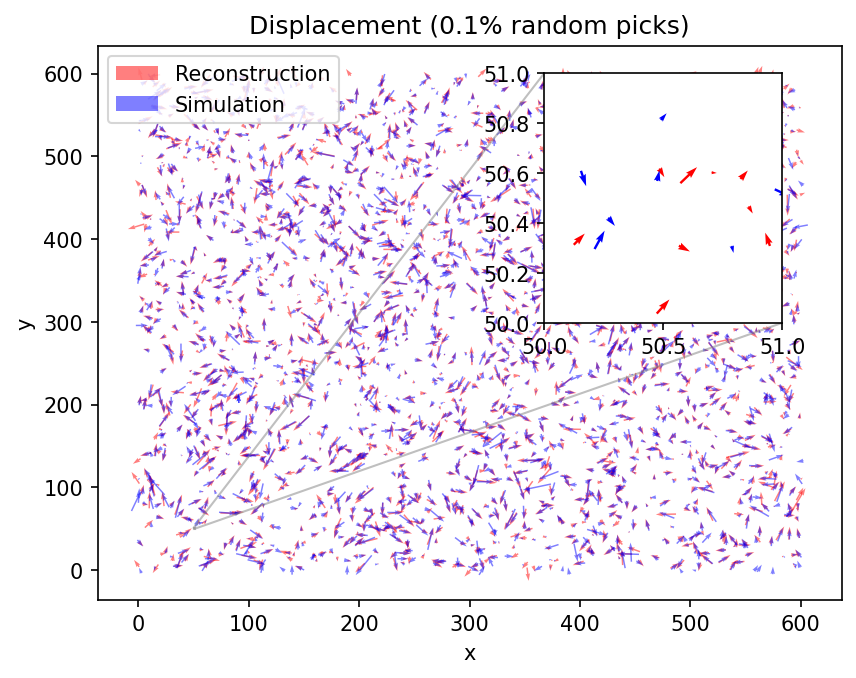

In [13]:
fig, ax = plt.subplots(1, 1, facecolor="white", dpi=150)

Q1 = plt.quiver(schmit_output["pos"][rnd,0], schmit_output["pos"][rnd,1], schmit_output["vel"][rnd,0], schmit_output["vel"][rnd,1], width=0.002, color='r', alpha=.5, label="Reconstruction")
Q2 = plt.quiver(hpos[rnd,0], hpos[rnd,1], hdisp[rnd,0], hdisp[rnd,1], width=0.002, color='b', alpha=.5, label="Simulation")

ax1 = ax.inset_axes([.6,.5,.32,.45])
ax1.quiver(schmit_output["pos"][:,0], schmit_output["pos"][:,1], schmit_output["vel"][:,0], schmit_output["vel"][:,1], color='r', width=0.01, scale=100)
ax1.quiver(hpos[:,0], hpos[:,1], hdisp[:,0], hdisp[:,1], color='b', width=0.01, scale=100)
ax1.set_xlim(50, 51)
ax1.set_ylim(50, 51)
ax.indicate_inset_zoom(ax1, facecolor='w')

ax.legend()

plt.xlabel("x"); plt.ylabel("y")
plt.title("Displacement (0.1% random picks)")

In [13]:
# rate = .1
# rnd = np.random.randint(low=0, high=hdisp.shape[0], size=int(hdisp.shape[0]*rate))

data_schmit = pd.DataFrame(np.hstack([schmit_output["pos"], schmit_output["vel"]]), columns=["x", "y", "z", "vx","vy","vz"])
data_schmit["type"] = "schmit"
vtot_schmit = np.sqrt(np.sum(np.power(schmit_output["vel"], 2), axis=1))

data_simu = pd.DataFrame(np.hstack([hpos, hdisp]), columns=["x", "y", "z", "vx","vy","vz"])
data_simu["type"] = "simu"
vtot_simu = np.sqrt(np.sum(np.power(hdisp, 2), axis=1))

data = pd.concat([data_schmit, data_simu])
del data_simu, data_schmit
gc.collect()

64

352

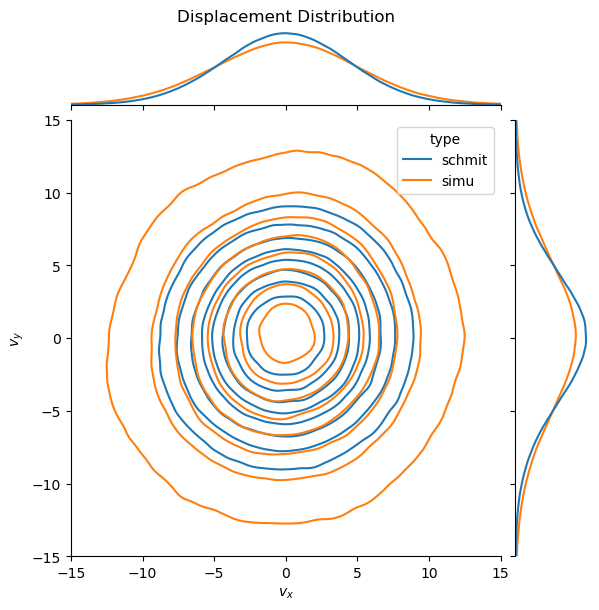

In [15]:
g = sns.jointplot(x="vx", y="vy", data=data, hue="type", kind="kde", color="k", label="1% from resconstruction")
# g.plot_joint(plt.scatter, s=1, linewidth=1, marker="+", alpha=1, hue="type")

g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$v_x$", "$v_y$")

g.ax_marg_x.set_title("Displacement Distribution")
g.ax_joint.set_xlim(-15, 15)
g.ax_joint.set_ylim(-15, 15)

del data
gc.collect()

In [14]:
def DensityPlot(axes, x, y, label, cov_factor=.25, hist=False, bins=20, color_index:int=0, edgecolor=None, histtype="bar"):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    density = scipy.stats.gaussian_kde(y)
    density.covariance_factor = lambda : cov_factor
    density._compute_covariance()
    axes.plot(x, density(x), label=label, color=colors[color_index])
    if hist == True:
        axes.hist(y, bins=bins, density=True, alpha=.5, color=colors[color_index], edgecolor=edgecolor, histtype=histtype)
    axes.set_xlim(x[0], x[-1])
    
def Chi2Plot(axes, x, y, label=None, color_index:int=0, plot=True):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    df, loc, scale = scipy.stats.chi2.fit(y)
    chiDistribution = scipy.stats.chi2(df, loc, scale)
    if plot:
        if label == None:
            label = "$\chi^2(%.2f)$"%(df)
        axes.plot(x, chiDistribution.pdf(x), color=colors[color_index], label=label, linestyle="dashed")
    return df, loc, scale

def NormPlot(axes, x, y, label=None, color_index:int=0, plot=True):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    loc, scale = scipy.stats.norm.fit(y)
    mean = np.mean(y)
    sigma = np.sqrt(np.var(y))
    skew = scipy.stats.skew(y)
    kur = scipy.stats.kurtosis(y)
    normDistribution = scipy.stats.norm(loc, scale)
    if plot:
        if label == None:
            label = "$\mathbb{N}$(%.2f, %.2f)"%(mean, sigma)
        axes.plot(x, normDistribution.pdf(x), color=colors[color_index], label=label, linestyle="dashed")
    return mean, sigma, skew, kur

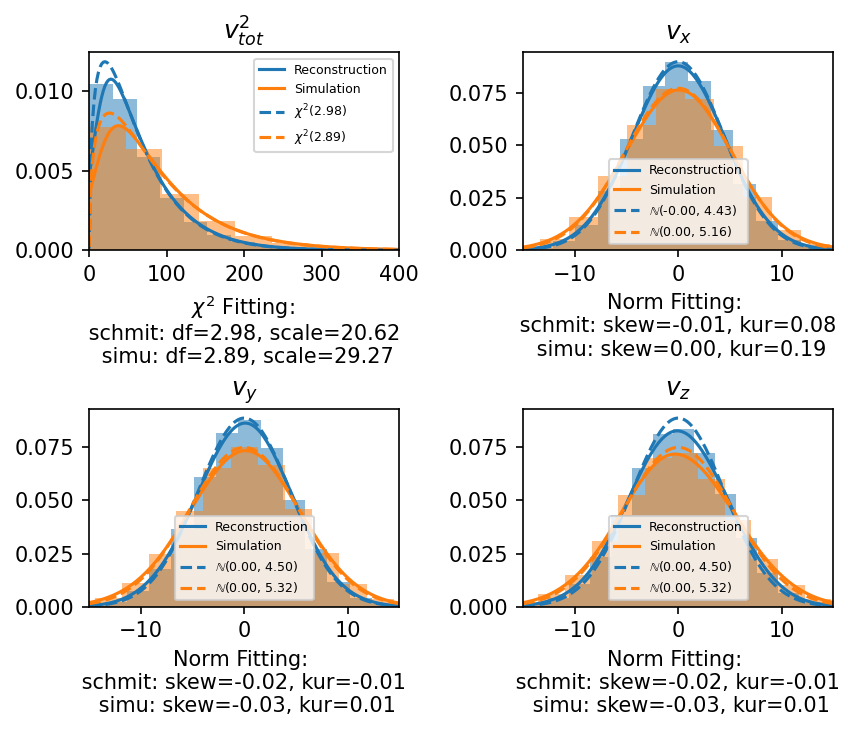

In [14]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots(2, 2, facecolor="white", dpi=150)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.8)

xs = np.linspace(0, 400, 200)
myMatplotlibPlot.DensityPlot(ax[0,0], xs, vtot_schmit**2, label="Reconstruction", hist=True, color_index=0)
myMatplotlibPlot.DensityPlot(ax[0,0], xs, vtot_simu**2, label="Simulation", hist=True, color_index=1)
df_schmit, loc_schmit, scale_schmit = myMatplotlibPlot.Chi2Plot(ax[0,0], xs, vtot_schmit**2, color_index=0)
df_simu, loc_simu, scale_simu = myMatplotlibPlot.Chi2Plot(ax[0,0], xs, vtot_simu**2, color_index=1)
ax[0,0].set_xlabel("$\chi^2$ Fitting: \n schmit: df=%.2f, scale=%.2f \n simu: df=%.2f, scale=%.2f"%(df_schmit, scale_schmit, df_simu, scale_simu))
ax[0,0].set_title("$v_{tot}^2$")
ax[0,0].legend(fontsize=6)

xs = np.linspace(-15, 15, 200)
myMatplotlibPlot.DensityPlot(ax[0,1], xs, schmit_output["vel"][:,0], label="Reconstruction", hist=True, color_index=0)
myMatplotlibPlot.DensityPlot(ax[0,1], xs, hdisp[:,0], label="Simulation", hist=True, color_index=1)
mean_schmit, sigma_schmit, skew_schmit, kur_schmit = myMatplotlibPlot.NormPlot(ax[0,1], xs, schmit_output["vel"][:,0], color_index=0)
mean_simu, sigma_simu, skew_simu, kur_simu = myMatplotlibPlot.NormPlot(ax[0,1], xs, hdisp[:,0], color_index=1)
ax[0,1].set_xlabel("Norm Fitting: \n schmit: skew=%.2f, kur=%.2f \n simu: skew=%.2f, kur=%.2f"%(skew_schmit, kur_schmit, skew_simu, kur_simu))
ax[0,1].set_title("$v_x$")
ax[0,1].legend(fontsize=6)

xs = np.linspace(-15, 15, 200)
myMatplotlibPlot.DensityPlot(ax[1,0], xs, schmit_output["vel"][:,1], label="Reconstruction", hist=True, color_index=0)
myMatplotlibPlot.DensityPlot(ax[1,0], xs, hdisp[:,1], label="Simulation", hist=True, color_index=1)
mean_schmit, sigma_schmit, skew_schmit, kur_schmit = myMatplotlibPlot.NormPlot(ax[1,0], xs, schmit_output["vel"][:,1], color_index=0)
mean_simu, sigma_simu, skew_simu, kur_simu = myMatplotlibPlot.NormPlot(ax[1,0], xs, hdisp[:,1], color_index=1)
ax[1,0].set_xlabel("Norm Fitting: \n schmit: skew=%.2f, kur=%.2f \n simu: skew=%.2f, kur=%.2f"%(skew_schmit, kur_schmit, skew_simu, kur_simu))
ax[1,0].set_title("$v_y$")
ax[1,0].legend(fontsize=6)

xs = np.linspace(-15, 15, 200)
myMatplotlibPlot.DensityPlot(ax[1,1], xs, schmit_output["vel"][:,2], label="Reconstruction", hist=True, color_index=0)
density = myMatplotlibPlot.DensityPlot(ax[1,1], xs, hdisp[:,2], label="Simulation", hist=True, color_index=1)
mean_schmit, sigma_schmit, skew_schmit, kur_schmit = myMatplotlibPlot.NormPlot(ax[1,1], xs, schmit_output["vel"][:,1], color_index=0)
mean_simu, sigma_simu, skew_simu, kur_simu = myMatplotlibPlot.NormPlot(ax[1,1], xs, hdisp[:,1], color_index=1)
ax[1,1].set_xlabel("Norm Fitting: \n schmit: skew=%.2f, kur=%.2f \n simu: skew=%.2f, kur=%.2f"%(skew_schmit, kur_schmit, skew_simu, kur_simu))
ax[1,1].set_title("$v_z$")
ax[1,1].legend(fontsize=6)

#### Magnitude difference

In [15]:
def VectorCosine(u, v):
    norm_u = np.sqrt(np.sum(np.square(u, dtype=np.float64), axis=1))
    norm_v = np.sqrt(np.sum(np.square(v, dtype=np.float64), axis=1))
    cosine = np.sum(u * v, axis=1, dtype=np.float64) / norm_u / norm_v
    return cosine

def VectorProjection(u, v):
    """u is the vector to be projected onto v
    """
    norm_v = np.sqrt(np.sum(np.square(v, dtype=np.float64), axis=1))
    proj = np.sum(u * v, axis=1, dtype=np.float64) / norm_v
    return proj

In [16]:
v_tot_diff = vtot_schmit - vtot_simu
v_proj_diff = VectorProjection(schmit_output["vel"], hdisp) - np.sqrt(np.sum(np.square(hdisp, dtype=np.float64), axis=1))
v_z_diff = schmit_output["vel"][:,2] - hdisp[:,2]

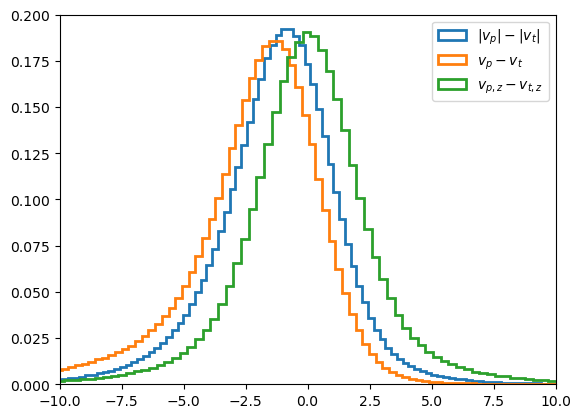

In [17]:
fig, ax = plt.subplots(1, 1, facecolor="white", dpi=100)

ax.hist(v_tot_diff, bins=200, density=True, histtype="step", label="$|v_p|-|v_t|$", linewidth=2)
ax.hist(v_proj_diff, bins=200, density=True, histtype="step", label="$v_p-v_t$", linewidth=2)
ax.hist(v_z_diff, bins=200, density=True, histtype="step", label="$v_{p,z}-v_{t,z}$", linewidth=2)

ax.set_xlim(-10, 10)
ax.set_ylim(0, 0.2)
ax.legend()

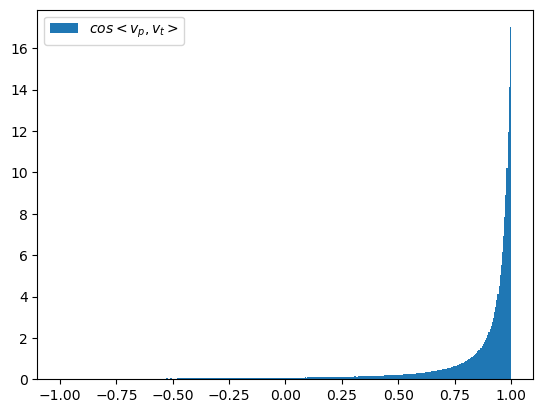

In [18]:
fig, ax = plt.subplots(1, 1, facecolor="white", dpi=100)

ax.hist(VectorCosine(schmit_output["vel"], hdisp), bins=400, density=True, label="$cos<v_p, v_t>$", linewidth=2)

# ax.set_xlim(0.8, 1.005)
ax.legend()

In [19]:
def JointHeatMapPlot(fig, axes, x, y, bins, xlabel="x", ylabel="y", normed=False, colorbar=True, lower=0.5, upper=99.5, scale=matplotlib.colors.Normalize, colormap=cm.jet):
    """
    numpy.histogram2d 得到的二维结果中x对应numpy数组的第0列，在使用imshow作图时对应了纵坐标轴，需要注意
    使用matplotlib控制的x,y轴也都是图像上的x,y轴，与Numpy数组的第0列，第一列是存在区别的
    """
    H = 0
    xedges = yedges = np.array([])
    try:
        if (x.shape == y.shape):
            Ndim = x.shape[1]
            for i in range(Ndim):
                tmp, xedges, yedges = np.histogram2d(x[:, i], y[:, i], bins=bins, normed=normed)
                H = H + tmp
        else:
            raise ValueError("x and y must have the same shape")
    except:
        H, xedges, yedges = np.histogram2d(x, y, bins=bins, normed=normed)
    if colorbar:
        vmax = np.percentile(H, upper)
        vmin = np.percentile(H, lower)
        norm = scale(vmin=vmin, vmax=vmax)
        pcm = axes.imshow(H, cmap=colormap, norm=norm, origin="lower")
        fig.colorbar(pcm, ax=axes, extend='both')
    else:
        axes.imshow(H)
    axes.set_xlabel(ylabel)
    axes.set_ylabel(xlabel)
    return H, xedges, yedges

In [20]:
def linear_b0(x, a):
    return a * x

def linear(x, a, b):
    return a * x + b

import scipy.odr
def linear_odr(p, x):
    return p[0] * x + p[1]

def linear_odr_b0(p, x):
    return p[0] * x

odr_linear_model = scipy.odr.Model(linear_odr)
odr_linear_b0_model = scipy.odr.Model(linear_odr_b0)

In [21]:
def table_offset(data, xedges, yedges=None, threshold=0, nonzero=True):
    if nonzero:
        data[data < 1e-5] = 1e-5
    xedges = (xedges[0:-1] + xedges[1:]) / 2
    if yedges is None:
        yedges = xedges
    else:
        yedges = (yedges[0:-1] + yedges[1:]) / 2
    if threshold > 0:
        threshold = threshold * np.max(data)
        tmp = np.zeros([len(data[data > threshold]), 3])
    else:
        tmp = np.zeros([data.size, 3])
    lenx, leny = data.shape
    count = 0
    for i in range(lenx):    # rows
        for j in range(leny):    # cols
            if data[i, j] > threshold:
                tmp[count, 0] = xedges[j]
                tmp[count, 1] = yedges[i]
                tmp[count, 2] = data[i, j]
                count += 1
    return tmp

##### JointHeatMap 调试文件

In [31]:
x = np.random.random(3)
y = np.random.random(3)

In [32]:
x

array([0.71443521, 0.98262962, 0.59104637])

In [33]:
y

array([0.0108225 , 0.42198448, 0.82295258])

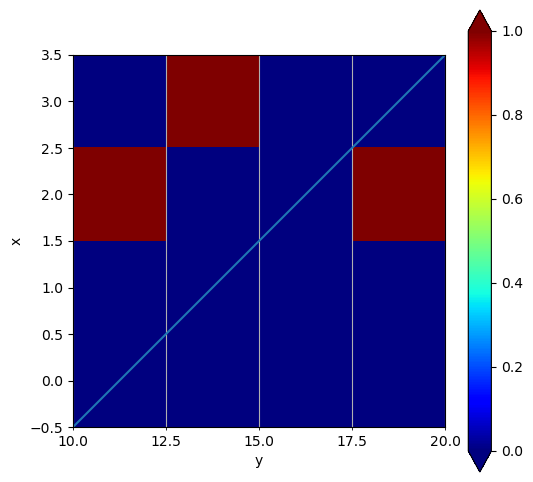

In [45]:
fig, ax = plt.subplots(1, 1, facecolor="white", dpi=100, figsize=(6, 6))
JointHeatMapPlot(fig, ax, x, y, bins=np.linspace(0, 1, 5))
plt.xticks([])
plt.xticks(np.linspace(-0.5, 3.5, 5), np.linspace(10, 20, 5), minor=True)# 使副刻度重新映射为指定的值
plt.plot([-0.5, 3.5], [-0.5, 3.5])
# ax.xaxis.set_minor_formatter('{x:.1f}') # 使副刻度显示对应的值
ax.grid(which="minor")

In [66]:
np.polyfit(vtot_simu, vtot_schmit, deg=1)

/home/zhanglf/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3552: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


array([0.41777578, 3.83710745])

In [71]:
np.polyfit(vtot_simu - np.mean(vtot_simu), vtot_schmit, deg=1)

array([0.60984475, 7.21603669])

In [69]:
np.polyval(p, vtot_simu - np.mean(vtot_simu))

array([7.864612, 6.279516, 6.810074, ..., 3.670827, 5.569892, 5.861781],
      dtype=float32)

In [70]:
vtot_schmit

array([6.6411266, 6.769905 , 8.795587 , ..., 2.9453187, 4.8669553,
       5.8774066], dtype=float32)

In [64]:
vtot_simu - np.mean(vtot_simu)

array([ 1.063509 , -1.5356708, -0.6656828, ..., -5.813299 , -2.6992855,
       -2.2206569], dtype=float32)

$k (x - \bar{x}) + b = y$

$kx + b - k\bar{x} = y$

##### HeatMap 与 散点比较

(-16.0, 16.0)

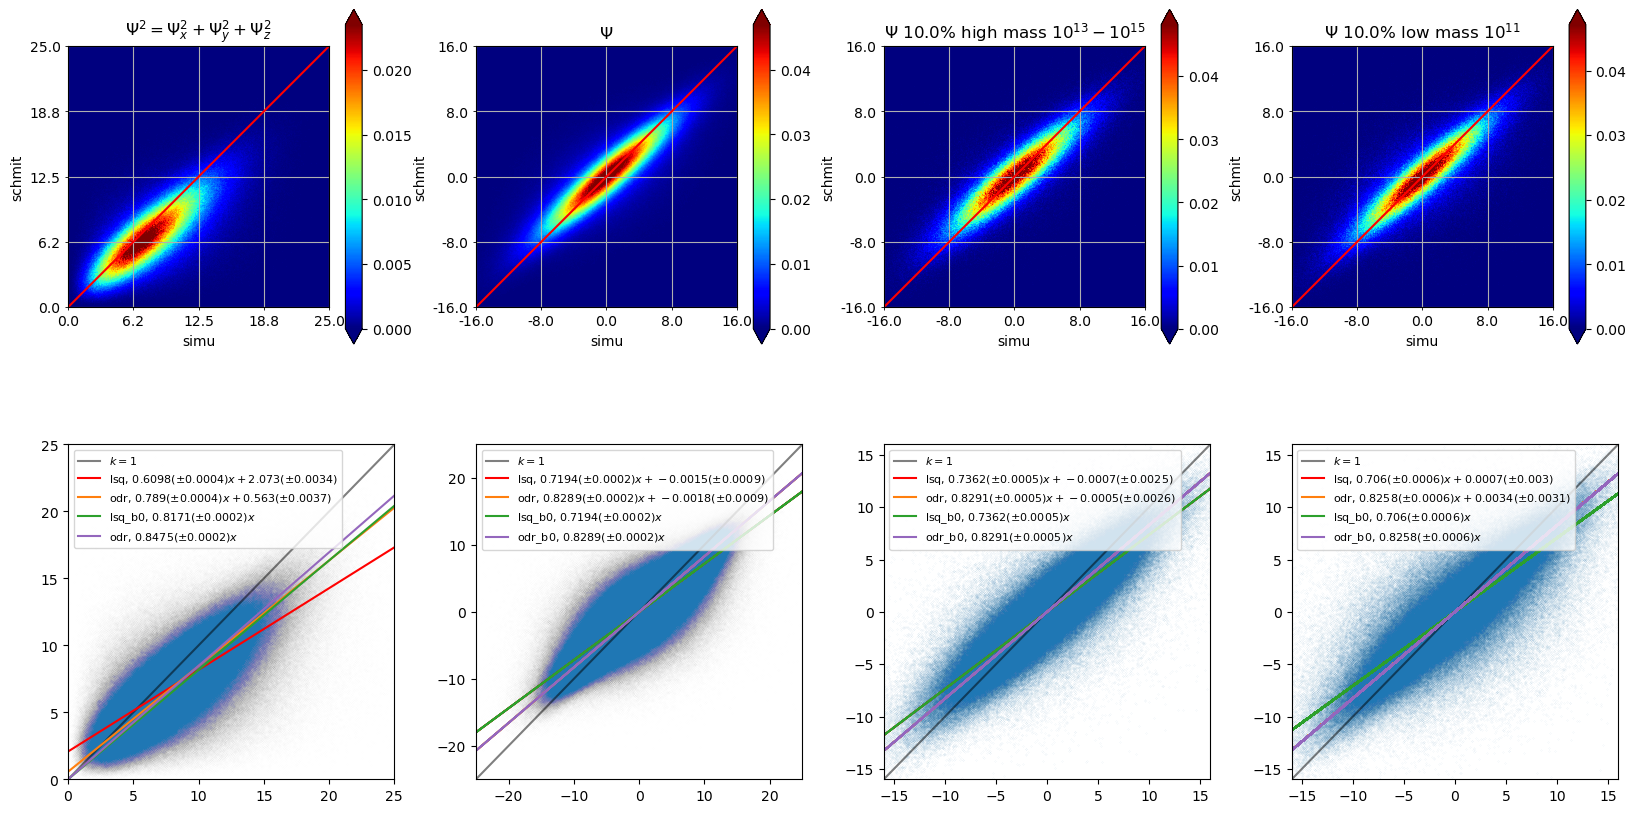

In [22]:
# fig, ax = plt.subplots(2, 4, facecolor="white", dpi=100, figsize=(24, 9))
fig, ax = plt.subplots(2, 4, facecolor="white", dpi=100, figsize=(20, 10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3)


H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 0], vtot_schmit, vtot_simu, ylabel="simu", xlabel="schmit", bins=np.linspace(0, 25, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 0].plot([-0.5, 510.5], [-0.5, 510.5], c='r')
ax[0, 0].set_xticks([])
ax[0, 0].set_xticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(xedges[0], xedges[-1], 5), 1), minor=True)
ax[0, 0].set_yticks([])
ax[0, 0].set_yticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(yedges[0], yedges[-1], 5), 1), minor=True)
ax[0, 0].grid(which="minor")
ax[0, 0].set_title("$\Psi^2 = \Psi_x^2 + \Psi_y^2 + \Psi_z^2$")

pcm = ax[1, 0].scatter(vtot_simu, vtot_schmit, s=.0001, alpha=.3)
ax[1, 0].plot([0, 30], [0, 30], c='k', alpha=.5, label="$k=1$")
# LSQ Fitting
popt, pcov = scipy.optimize.curve_fit(linear, vtot_simu, vtot_schmit, p0=(0.9, 0))
ax[1, 0].plot(np.linspace(0, 30, 200), linear(np.linspace(0, 30, 200), *popt), color='r', label=f"lsq, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x + {round(popt[1], 4)} (\pm {round(np.sqrt(np.diag(pcov))[1], 4)})$")
# ODR Fitting
odr_linear_data = scipy.odr.Data(vtot_simu, vtot_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_model, beta0=[1, 0]).run()
ax[1, 0].plot(np.linspace(0, 30, 200), linear_odr(odr_linear_output.beta, np.linspace(0, 30, 200)), color=PlotParams.colors["default"][1], label=f"odr, ${round(odr_linear_output.beta[0], 3)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x + {round(odr_linear_output.beta[1], 3)} (\pm {round(odr_linear_output.sd_beta[1], 4)})$")
# Fitting for linear and b=0
# LSQ Fitting
popt, pcov = scipy.optimize.curve_fit(linear_b0, vtot_simu, vtot_schmit, p0=(0.9))
ax[1, 0].plot(np.linspace(0, 30, 200), linear_b0(np.linspace(0, 30, 200), *popt), color=PlotParams.colors["default"][2], label=f"lsq_b0, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x$")
# ODR Fitting
odr_linear_data = scipy.odr.Data(vtot_simu, vtot_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_b0_model, beta0=[1]).run()
ax[1, 0].plot(np.linspace(0, 30, 200), linear_odr_b0(odr_linear_output.beta, np.linspace(0, 30, 200)), color=PlotParams.colors["default"][4], label=f"odr, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x $")

ax[1, 0].legend(loc="upper left", fontsize=8)
ax[1, 0].set_xlim(0, 25); ax[1, 0].set_ylim(0, 25)


H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 1], schmit_output["vel"], hdisp, ylabel="simu", xlabel="schmit", bins=np.linspace(-16, 16, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 1].plot([-0.5, 510.5], [-0.5, 510.5], c='r')
ax[0, 1].set_xticks([])
ax[0, 1].set_xticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(xedges[0], xedges[-1], 5), 1), minor=True)
ax[0, 1].set_yticks([])
ax[0, 1].set_yticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(yedges[0], yedges[-1], 5), 1), minor=True)
ax[0, 1].grid(which="minor")
ax[0, 1].set_title("$\Psi$")

v_simu = np.concatenate((hdisp[:, 0], hdisp[:, 1], hdisp[:, 2]))
v_schmit = np.concatenate((schmit_output["vel"][:, 0], schmit_output["vel"][:, 1], schmit_output["vel"][:, 2]))
popt, pcov = scipy.optimize.curve_fit(linear, v_simu, v_schmit, p0=(0.9, 0))
pcm = ax[1, 1].scatter(v_simu, v_schmit, s=.0001, alpha=.3)
ax[1, 1].plot([-30, 30], [-30, 30], c='k', alpha=.5, label="$k=1$")
ax[1, 1].plot(v_simu, linear(v_simu, *popt), color='r', label=f"lsq, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x + {round(popt[1], 4)} (\pm {round(np.sqrt(np.diag(pcov))[1], 4)})$") 
# ODR Fitting
odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_model, beta0=[1, 0]).run()
ax[1, 1].plot(v_simu, linear_odr(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][1], label=f"odr, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x + {round(odr_linear_output.beta[1], 4)} (\pm {round(odr_linear_output.sd_beta[1], 4)})$")
# Fitting for linear and b=0
# LSQ Fitting
popt, pcov = scipy.optimize.curve_fit(linear_b0, v_simu, v_schmit, p0=(0.9))
ax[1, 1].plot(v_simu, linear_b0(v_simu, *popt), color=PlotParams.colors["default"][2], label=f"lsq_b0, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x$")
# ODR Fitting
odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_b0_model, beta0=[1]).run()
ax[1, 1].plot(v_simu, linear_odr_b0(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][4], label=f"odr_b0, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x $")
beta_all = odr_linear_output.beta
beta_all_lsq = popt[0]

ax[1, 1].legend(loc="upper left", fontsize=8)
ax[1, 1].set_xlim(-25, 25); ax[1, 1].set_ylim(-25, 25)


rate_upper = 0.10
H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 2], schmit_output["vel"][0:int(rate_upper * len(hdisp))], hdisp[0:int(rate_upper * len(hdisp))], ylabel="simu", xlabel="schmit", bins=np.linspace(-16, 16, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 2].plot([-0.5, 510.5], [-0.5, 510.5], c='r')
ax[0, 2].set_xticks([])
ax[0, 2].set_xticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(xedges[0], xedges[-1], 5), 1), minor=True)
ax[0, 2].set_yticks([])
ax[0, 2].set_yticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(yedges[0], yedges[-1], 5), 1), minor=True)
ax[0, 2].grid(which="minor")
ax[0, 2].set_title(f"$\Psi$ {rate_upper * 100}% high mass $10^{{13}}-10^{{15}}$")

v_simu = np.concatenate((hdisp[0:int(rate_upper * len(hdisp))][:, 0], hdisp[0:int(rate_upper * len(hdisp))][:, 1], hdisp[0:int(rate_upper * len(hdisp))][:, 2]))
v_schmit = np.concatenate((schmit_output["vel"][0:int(rate_upper * len(hdisp))][:, 0], schmit_output["vel"][0:int(rate_upper * len(hdisp))][:, 1], schmit_output["vel"][0:int(rate_upper * len(hdisp))][:, 2]))
popt, pcov = scipy.optimize.curve_fit(linear, v_simu, v_schmit, p0=(0.9, 0))
pcm = ax[1, 2].scatter(v_simu, v_schmit, s=.005, alpha=.3)
ax[1, 2].plot([-20, 20], [-20, 20], c='k', alpha=.5, label="$k=1$")
ax[1, 2].plot(v_simu, linear(v_simu, *popt), color='r', label=f"lsq, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x + {round(popt[1], 4)} (\pm {round(np.sqrt(np.diag(pcov))[1], 4)})$") 
# ODR Fitting
odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_model, beta0=[1, 0]).run()
ax[1, 2].plot(v_simu, linear_odr(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][1], label=f"odr, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x + {round(odr_linear_output.beta[1], 4)} (\pm {round(odr_linear_output.sd_beta[1], 4)})$")
# Fitting for linear and b=0
# LSQ Fitting
popt, pcov = scipy.optimize.curve_fit(linear_b0, v_simu, v_schmit, p0=(0.9))
ax[1, 2].plot(v_simu, linear_b0(v_simu, *popt), color=PlotParams.colors["default"][2], label=f"lsq_b0, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x$")
# ODR Fitting
odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_b0_model, beta0=[1]).run()
ax[1, 2].plot(v_simu, linear_odr_b0(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][4], label=f"odr_b0, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x $")
beta_upper = odr_linear_output.beta
beta_upper_lsq = popt[0]

ax[1, 2].legend(loc="upper left", fontsize=8)
ax[1, 2].set_xlim(-16, 16); ax[1, 2].set_ylim(-16, 16)


rate_lower = 0.90
H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 3], schmit_output["vel"][int(rate_lower * len(hdisp)):], hdisp[int(rate_lower * len(hdisp)):], xlabel="schmit", ylabel="simu", bins=np.linspace(-16, 16, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 3].plot([-0.5, 510.5], [-0.5, 510.5], c='r')
ax[0, 3].set_xticks([])
ax[0, 3].set_xticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(xedges[0], xedges[-1], 5), 1), minor=True)
ax[0, 3].set_yticks([])
ax[0, 3].set_yticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(yedges[0], yedges[-1], 5), 1), minor=True)
ax[0, 3].grid(which="minor")
ax[0, 3].set_title(f"$\Psi$ {100 - rate_lower * 100}% low mass $10^{{11}}$")

v_simu = np.concatenate((hdisp[int(rate_lower * len(hdisp)):][:, 0], hdisp[int(rate_lower * len(hdisp)):][:, 1], hdisp[int(rate_lower * len(hdisp)):][:, 2]))
v_schmit = np.concatenate((schmit_output["vel"][int(rate_lower * len(hdisp)):][:, 0], schmit_output["vel"][int(rate_lower * len(hdisp)):][:, 1], schmit_output["vel"][int(rate_lower * len(hdisp)):][:, 2]))
popt, pcov = scipy.optimize.curve_fit(linear, v_simu, v_schmit, p0=(0.8, 0))
pcm = ax[1, 3].scatter(v_simu, v_schmit, s=.005, alpha=.3)
ax[1, 3].plot([-20, 20], [-20, 20], c='k', alpha=.5, label="$k=1$")
ax[1, 3].plot(v_simu, linear(v_simu, *popt), color='r', label=f"lsq, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x + {round(popt[1], 4)} (\pm {round(np.sqrt(np.diag(pcov))[1], 4)})$") 
# ODR Fitting
odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_model, beta0=[1, 0]).run()
ax[1, 3].plot(v_simu, linear_odr(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][1], label=f"odr, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x + {round(odr_linear_output.beta[1], 4)} (\pm {round(odr_linear_output.sd_beta[1], 4)})$")
# Fitting for linear and b=0
# LSQ Fitting
popt, pcov = scipy.optimize.curve_fit(linear_b0, v_simu, v_schmit, p0=(0.9))
ax[1, 3].plot(v_simu, linear_b0(v_simu, *popt), color=PlotParams.colors["default"][2], label=f"lsq_b0, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x$")
# ODR Fitting
odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_b0_model, beta0=[1]).run()
ax[1, 3].plot(v_simu, linear_odr_b0(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][4], label=f"odr_b0, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x $")
beta_lower = odr_linear_output.beta
beta_lower_lsq = popt[0]

ax[1, 3].legend(loc="upper left", fontsize=8)
ax[1, 3].set_xlim(-16, 16); ax[1, 3].set_ylim(-16, 16)

In [23]:
# nrows = 4
# ncols = 5
# fig, ax = plt.subplots(nrows, ncols, facecolor="white", dpi=100, figsize=(20, 16))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3)

start = 0
N = 20
beta = []
for i in range(N):
    # m = i // ncols
    # n = i % ncols
    end = int(1 / N * (i + 1) * len(hdisp))

    v_simu = np.concatenate((hdisp[start:end][:, 0], hdisp[start:end][:, 1], hdisp[start:end][:, 2]))
    v_schmit = np.concatenate((schmit_output["vel"][start:end][:, 0], schmit_output["vel"][start:end][:, 1], schmit_output["vel"][start:end][:, 2]))
    # Fitting for linear and b=0
    # LSQ Fitting
    # popt, pcov = scipy.optimize.curve_fit(linear_b0, v_simu, v_schmit, p0=(1))
    # ax[m, n].plot(v_simu, linear_b0(v_simu, *popt), color=PlotParams.colors["default"][0], label=f"lsq_b0, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x$")
    # ODR Fitting
    odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
    odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_b0_model, beta0=[1]).run()
    # ax[m, n].plot(v_simu, linear_odr_b0(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][1], label=f"odr_b0, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x $")
    beta.append(odr_linear_output.beta[0])

    # ax[m, n].scatter(v_simu, v_schmit, s=.0005, alpha=.5)

    # ax[m, n].set_title(f"${5 * i}\%$-${5 * (i + 1)}\%$ high mass")
    # ax[m, n].legend(loc="upper left", fontsize=8)
    # ax[m, n].set_xlim(-16, 16); ax[m, n].set_ylim(-16, 16)
    start = end
beta = np.array(beta)

#### 观察scale后的数据是否正确分布

(-25.0, 25.0)

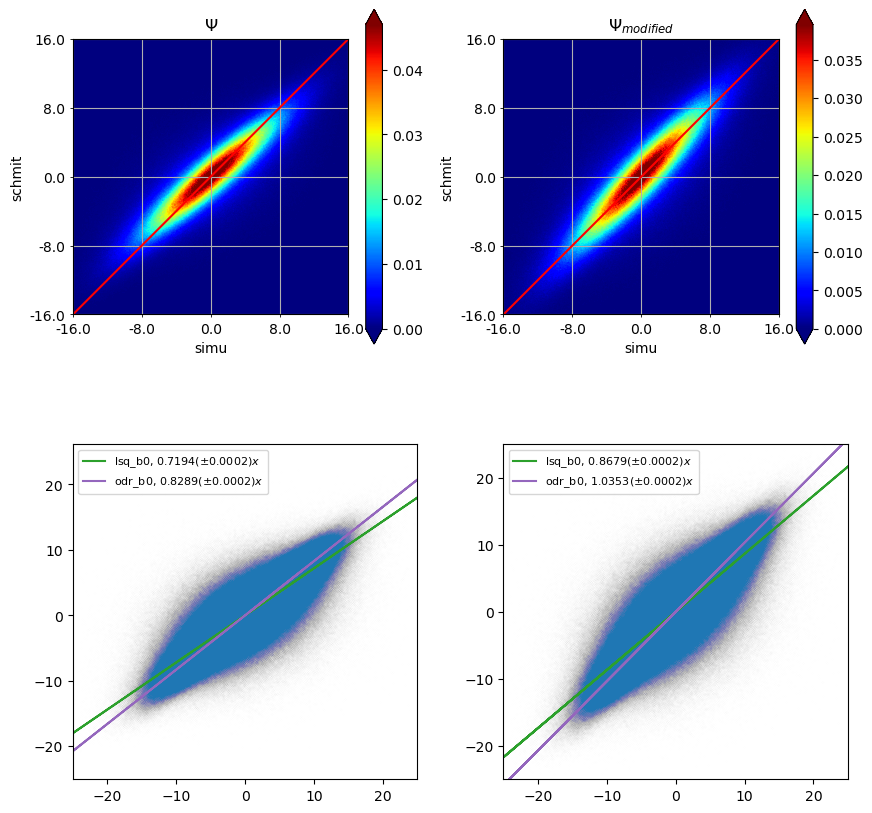

In [24]:
# fig, ax = plt.subplots(2, 4, facecolor="white", dpi=100, figsize=(24, 9))
fig, ax = plt.subplots(2, 2, facecolor="white", dpi=100, figsize=(10, 10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3)


H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 0], schmit_output["vel"], hdisp, ylabel="simu", xlabel="schmit", bins=np.linspace(-16, 16, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 0].plot([-0.5, 510.5], [-0.5, 510.5], c='r')
ax[0, 0].set_xticks([])
ax[0, 0].set_xticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(xedges[0], xedges[-1], 5), 1), minor=True)
ax[0, 0].set_yticks([])
ax[0, 0].set_yticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(yedges[0], yedges[-1], 5), 1), minor=True)
ax[0, 0].grid(which="minor")
ax[0, 0].set_title("$\Psi$")

v_simu = np.concatenate((hdisp[:, 0], hdisp[:, 1], hdisp[:, 2]))
v_schmit = np.concatenate((schmit_output["vel"][:, 0], schmit_output["vel"][:, 1], schmit_output["vel"][:, 2]))
ax[1, 0].scatter(v_simu, v_schmit, s=.0001, alpha=.3)
# Fitting for linear and b=0
# LSQ Fitting
popt, pcov = scipy.optimize.curve_fit(linear_b0, v_simu, v_schmit, p0=(0.9))
ax[1, 0].plot(v_simu, linear_b0(v_simu, *popt), color=PlotParams.colors["default"][2], label=f"lsq_b0, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x$")
# ODR Fitting
odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_b0_model, beta0=[1]).run()
ax[1, 0].plot(v_simu, linear_odr_b0(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][4], label=f"odr_b0, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x $")
beta_all = odr_linear_output.beta

ax[1, 0].legend(loc="upper left", fontsize=8)
ax[1, 0].set_xlim(-25, 25); ax[1, 1].set_ylim(-25, 25)


H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 1], schmit_output["vel"] / beta_all, hdisp, ylabel="simu", xlabel="schmit", bins=np.linspace(-16, 16, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 1].plot([-0.5, 510.5], [-0.5, 510.5], c='r')
ax[0, 1].set_xticks([])
ax[0, 1].set_xticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(xedges[0], xedges[-1], 5), 1), minor=True)
ax[0, 1].set_yticks([])
ax[0, 1].set_yticks(np.linspace(-0.5, 510.5, 5), np.round(np.linspace(yedges[0], yedges[-1], 5), 1), minor=True)
ax[0, 1].grid(which="minor")
ax[0, 1].set_title("$\Psi_{modified}$")

v_simu = np.concatenate((hdisp[:, 0], hdisp[:, 1], hdisp[:, 2]))
v_schmit = np.concatenate((schmit_output["vel"][:, 0] / beta_all, schmit_output["vel"][:, 1] / beta_all, schmit_output["vel"][:, 2] / beta_all))
ax[1, 1].scatter(v_simu, v_schmit, s=.0001, alpha=.3)
# Fitting for linear and b=0
# LSQ Fitting
popt, pcov = scipy.optimize.curve_fit(linear_b0, v_simu, v_schmit, p0=(0.9))
ax[1, 1].plot(v_simu, linear_b0(v_simu, *popt), color=PlotParams.colors["default"][2], label=f"lsq_b0, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x$")
# ODR Fitting
odr_linear_data = scipy.odr.Data(v_simu, v_schmit)
odr_linear_output = scipy.odr.ODR(odr_linear_data, odr_linear_b0_model, beta0=[1]).run()
ax[1, 1].plot(v_simu, linear_odr_b0(odr_linear_output.beta, v_simu), color=PlotParams.colors["default"][4], label=f"odr_b0, ${round(odr_linear_output.beta[0], 4)} (\pm {round(odr_linear_output.sd_beta[0], 4)}) x $")

ax[1, 1].legend(loc="upper left", fontsize=8)
ax[1, 1].set_xlim(-25, 25); ax[1, 1].set_ylim(-25, 25)

#### 观察simu中的displacement与质量Bin之间的关系

23690

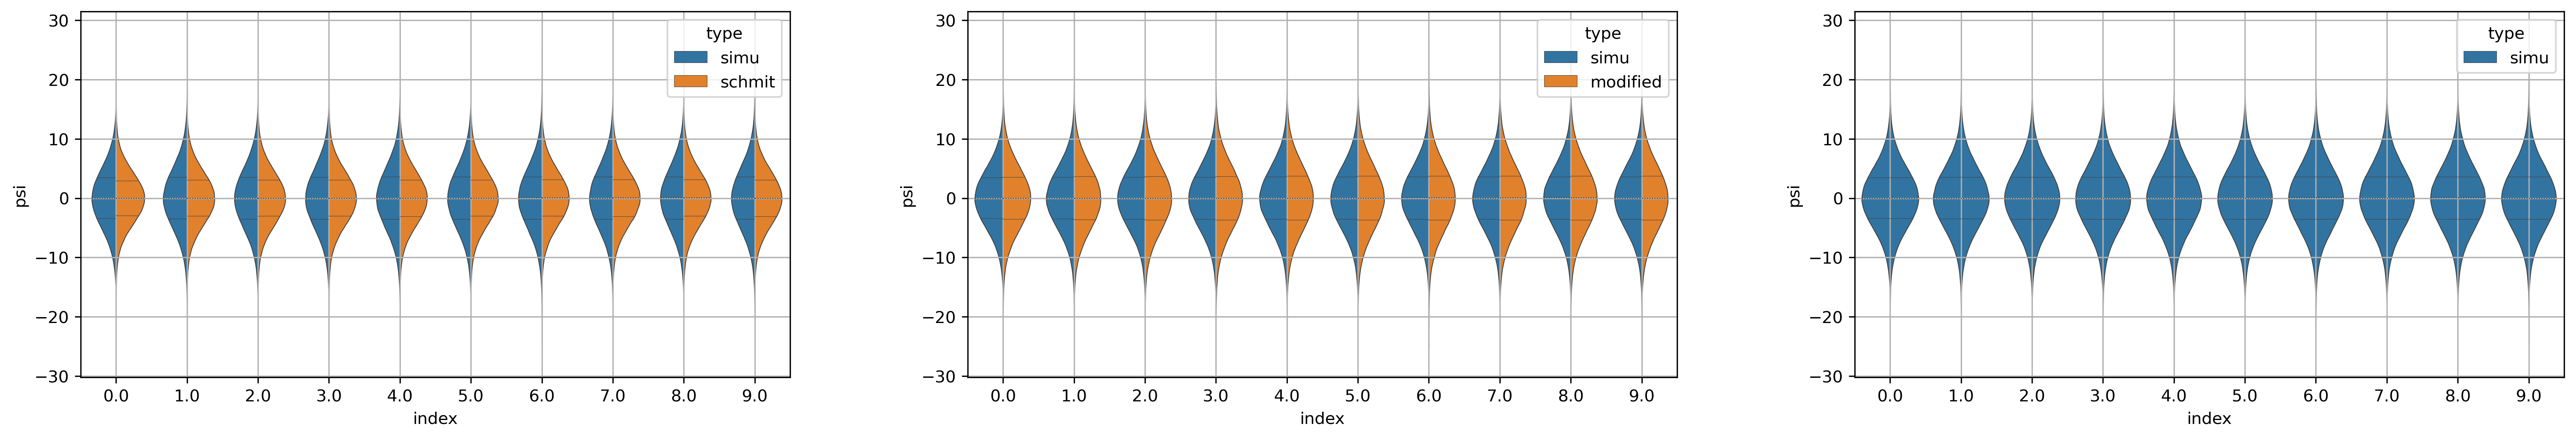

In [25]:
nbins = 10
h = int(len(schmit_output["vel"]) / nbins)
start = 0

index = np.ones(len(schmit_output["vel"]))
simu = np.concatenate((hdisp[:, 0], hdisp[:, 1], hdisp[:, 2]))
schmit = np.concatenate((schmit_output["vel"][:, 0], schmit_output["vel"][:, 1], schmit_output["vel"][:, 2]))
modified = np.concatenate((schmit_output["vel"][:, 0] / beta_all, schmit_output["vel"][:, 1] / beta_all, schmit_output["vel"][:, 2] / beta_all))

fig, ax = plt.subplots(1, 3, facecolor="white", dpi=300, figsize=(27, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.2)

for i in range(nbins):
    
    if i == nbins - 1:
        index[start:] = i
    else:
        index[start:start + h] = i
    start += h

index = np.concatenate((index, index, index))

data = pd.DataFrame({"psi":np.concatenate((simu, schmit)), "index":np.concatenate((index, index))})
data.loc[:, "type"] = "simu"
data.loc[len(index):, "type"] = "schmit"
sns.violinplot(data, x="index", y="psi", hue="type", ax=ax[0], split=True, inner="quartile", scale="area", scale_hue=False, cut=0, linewidth=0.5, palette=PlotParams.colors["default"])

data = pd.DataFrame({"psi":np.concatenate((simu, modified)), "index":np.concatenate((index, index))})
data.loc[:, "type"] = "simu"
data.loc[len(index):, "type"] = "modified"
sns.violinplot(data, x="index", y="psi", hue="type", ax=ax[1], split=True, inner="quartile", scale="area", scale_hue=False, cut=0, linewidth=0.5, palette=PlotParams.colors["default"])

data = pd.DataFrame({"psi":simu, "index":index})
data.loc[:, "type"] = "simu"
sns.violinplot(data, x="index", y="psi", hue="type", ax=ax[2], inner="quartile", scale="area", scale_hue=False, cut=0, linewidth=0.5, palette=PlotParams.colors["default"])

ax[0].grid()
ax[1].grid()
ax[2].grid()

del simu, schmit, modified, index, data
gc.collect()

Text(0.5, 1.0, 'beta / beta_all')

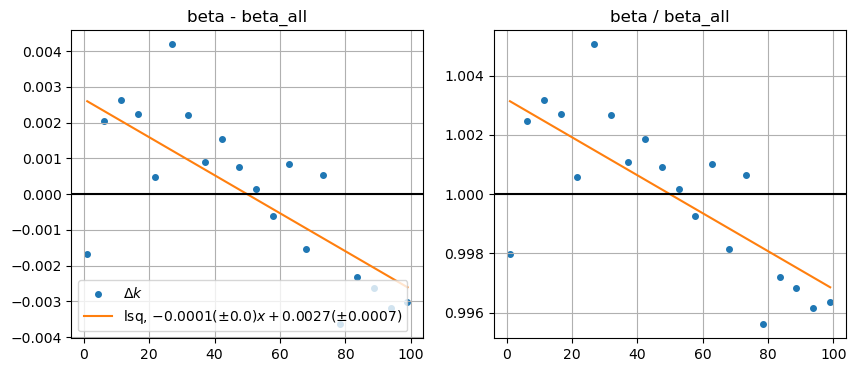

In [26]:
fig, ax = plt.subplots(1, 2, facecolor="white", dpi=100, figsize=(10, 4))

xx = (np.linspace(0, 98, N) + np.linspace(2, 100, N)) / 2
ax[0].scatter(xx, beta - beta_all, s=16, label="$\Delta k$")
popt, pcov = scipy.optimize.curve_fit(linear, xx, beta - beta_all, p0=(0.9, 0))
ax[0].plot(xx, linear(xx, *popt), color=PlotParams.colors["default"][1], label=f"lsq, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x + {round(popt[1], 4)} (\pm {round(np.sqrt(np.diag(pcov))[1], 4)})$")
# ax[0].bar(xx, beta - beta_all, label="$\Delta k$")
ax[0].axhline(0, color='k')
# ax[0].axvline(50, color='k')
ax[0].grid()
ax[0].legend(loc='lower left')
ax[0].set_title("beta - beta_all")

xx = (np.linspace(0, 98, N) + np.linspace(2, 100, N)) / 2
ax[1].scatter(xx, beta / beta_all, s=16, label="$\Delta k$")
popt, pcov = scipy.optimize.curve_fit(linear, xx, beta / beta_all, p0=(0.9, 0))
ax[1].plot(xx, linear(xx, *popt), color=PlotParams.colors["default"][1], label=f"lsq, ${round(popt[0], 4)} (\pm {round(np.sqrt(np.diag(pcov))[0], 4)})x + {round(popt[1], 4)} (\pm {round(np.sqrt(np.diag(pcov))[1], 4)})$")
# ax[0].bar(xx, beta - beta_all, label="$\Delta k$")
ax[1].axhline(1, color='k')
ax[1].grid()
# ax[1].legend(loc='lower left')
ax[1].set_title("beta / beta_all")

In [27]:
import copy
schmit_modified_linear = copy.deepcopy(schmit_output["vel"])
start = 0
for i in range(N):
    end = int(1 / N * (i + 1) * len(schmit_output["vel"]))
    schmit_modified_linear[start:end] = schmit_output["vel"][start:end] / ((2 * i + 1) * popt[0] + popt[1])
    start = end
print(schmit_modified_linear)

displacement.WriteDTFE("/home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_linear_005_g0512", Nall=len(hpos), BoxSize=600., pos=g_5["GroupPos"] - schmit_modified_linear, vel=schmit_modified_linear)

[[ 6.5722003  -0.5197909  -0.6042837 ]
 [-2.508294    1.9193226   5.964066  ]
 [-2.4073572   8.324106    1.3390855 ]
 ...
 [ 0.76494724 -2.3291433  -1.6287116 ]
 [ 3.0205464   3.7787297  -0.5015791 ]
 [ 5.405015    2.2653215  -0.386861  ]]


In [28]:
schmit_modified_specific = copy.deepcopy(schmit_output["vel"])
start = 0
for i in range(N):
    end = int(1 / N * (i + 1) * len(schmit_output["vel"]))
    schmit_modified_specific[start:end] = schmit_output["vel"][start:end] / beta[i]
    start = end
print(schmit_modified_specific)

displacement.WriteDTFE("/home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_specific_005_g0512", Nall=len(schmit_output["vel"]), BoxSize=600., pos=g_5["GroupPos"] - schmit_modified_specific, vel=schmit_modified_specific)

[[ 7.9700146  -0.6303431  -0.73280627]
 [-3.041773    2.3275354   7.232539  ]
 [-2.9193683  10.094526    1.62389   ]
 ...
 [ 0.92689735 -2.8222558  -1.9735328 ]
 [ 3.6600385   4.5787396  -0.6077705 ]
 [ 6.5493326   2.744922   -0.46876493]]


[Text(0, 0, '$v_{s,x}$'),
 Text(0, 1, '$v_{s,y}$'),
 Text(0, 2, '$v_{s,z}$'),
 Text(0, 3, '$v_{r,x}$'),
 Text(0, 4, '$v_{r,y}$'),
 Text(0, 5, '$v_{r,z}$')]

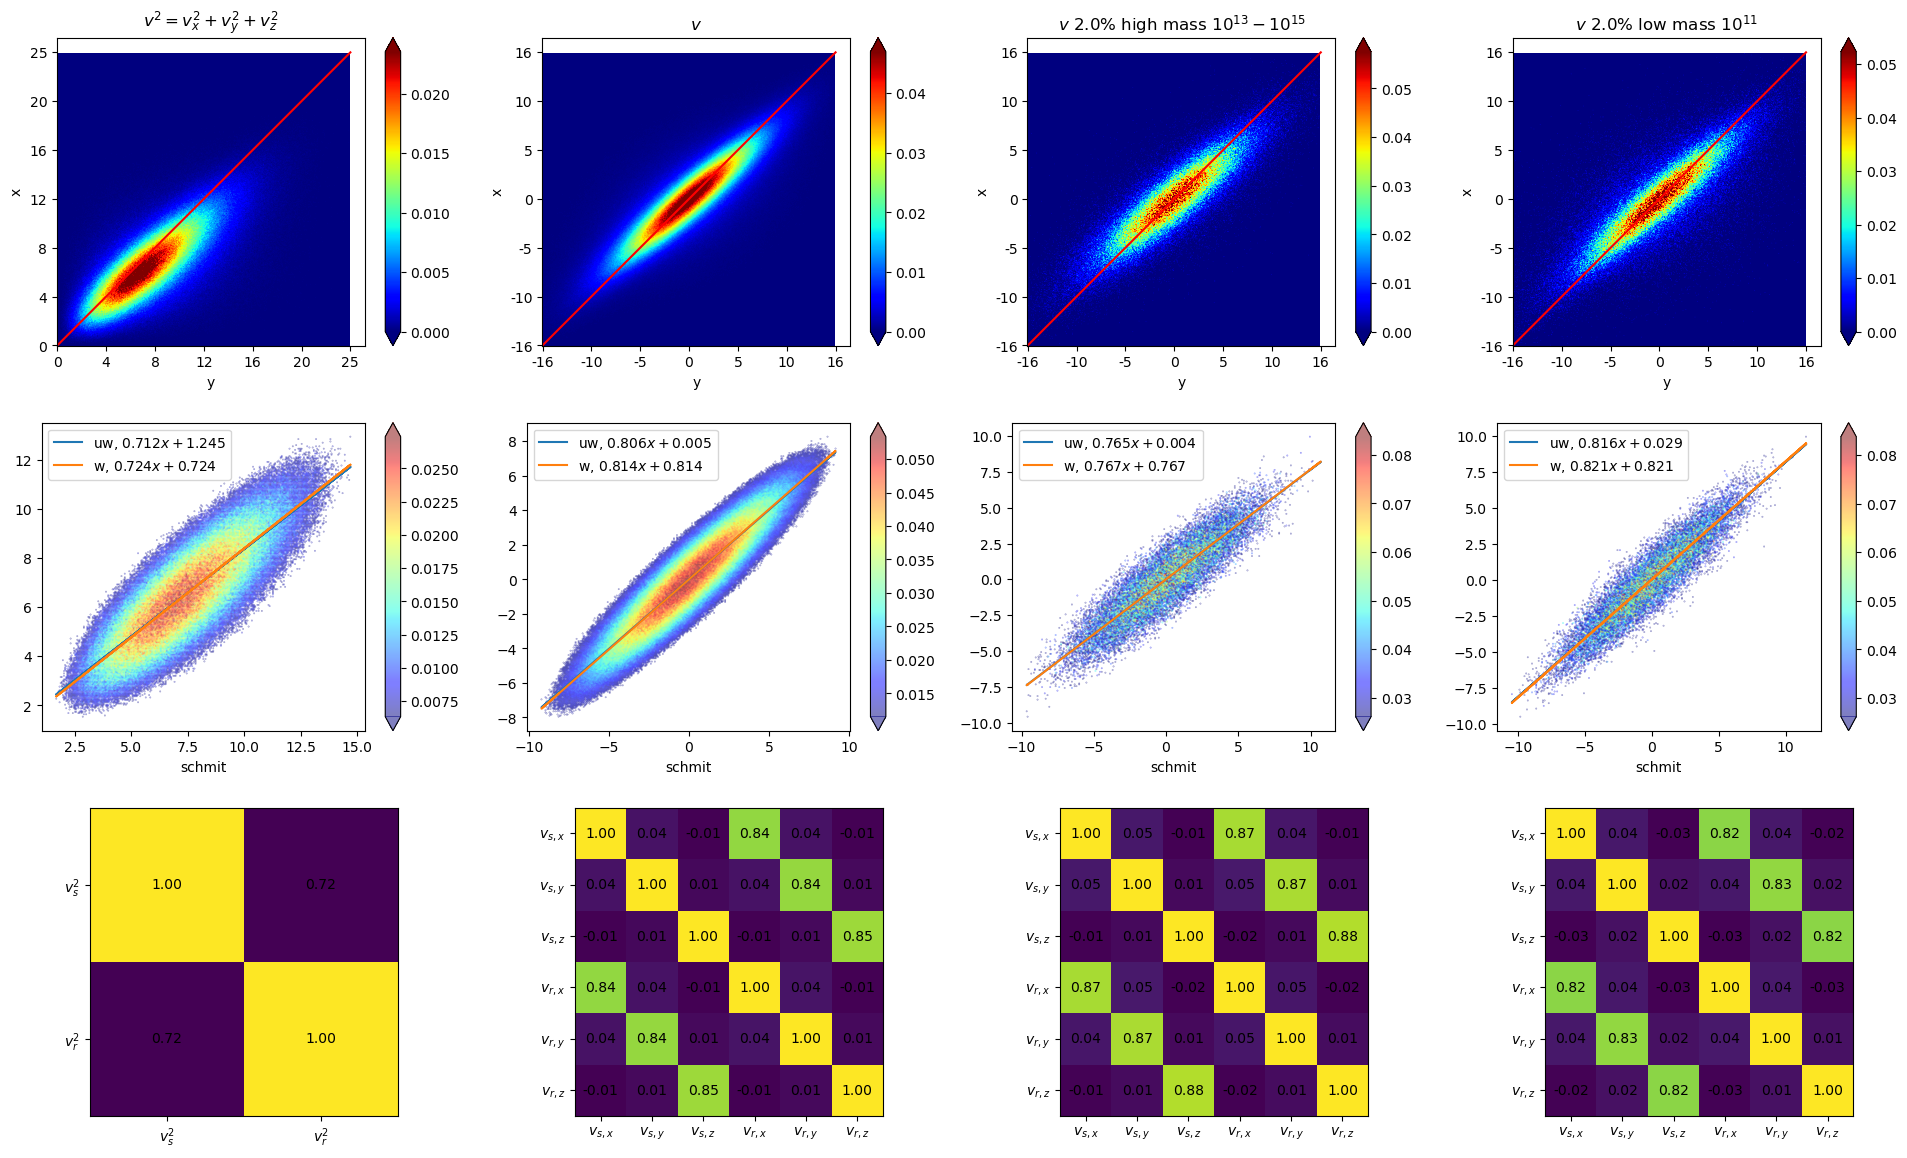

In [29]:
fig, ax = plt.subplots(3, 4, facecolor="white", dpi=100, figsize=(24, 14))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.25)


H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 0], vtot_schmit, vtot_simu, bins=np.linspace(0, 25, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 0].plot([0, 512], [0, 512], c='r')
ax[0, 0].set_xticks(np.linspace(0, 512, 7), (np.linspace(xedges[0], xedges[-1], 7)).astype("int"))
ax[0, 0].set_yticks(np.linspace(0, 512, 7), (np.linspace(yedges[0], yedges[-1], 7)).astype("int"))
ax[0, 0].set_title("$v^2 = v_x^2 + v_y^2 + v_z^2$")

tmp = table_offset(H, xedges, yedges, threshold=0.2)
popt_uw, pcov_uw = scipy.optimize.curve_fit(linear, tmp[:, 0], tmp[:, 1], p0=(2, -1))
popt_w, pcov_w = scipy.optimize.curve_fit(linear, tmp[:, 0], tmp[:, 1], p0=(2, -1), sigma=1 / tmp[:, 2], absolute_sigma=False)
pcm = ax[1, 0].scatter(tmp[:, 0], tmp[:, 1], s=.1, c=tmp[:, 2], cmap=cm.jet \
    , norm=Normalize(vmin=np.percentile(tmp[:, 2], .5), vmax=np.percentile(tmp[:, 2], 99.5)), alpha=.5)
fig.colorbar(pcm, ax=ax[1, 0], extend='both')
ax[1, 0].plot(tmp[:, 0], linear(tmp[:, 0], *popt_uw), label=f"uw, ${round(popt_uw[0], 3)}x + {round(popt_uw[1], 3)}$")
ax[1, 0].plot(tmp[:, 0], linear(tmp[:, 0], *popt_w), label=f"w, ${round(popt_w[0], 3)}x + {round(popt_w[0], 3)}$")
ax[1, 0].legend()
ax[1, 0].set_xlabel("schmit")

corr = np.corrcoef(vtot_schmit, vtot_simu, rowvar=False)
pcm = ax[2, 0].imshow(corr, cmap=cm.viridis)
for i in range(2):
    for j in range(2):
        ax[2, 0].text(j, i, "%.2f"%corr[i, j], ha="center", va="center")
ax[2, 0].set_xticks(range(2)); ax[2, 0].set_yticks(range(2))
ax[2, 0].set_xticklabels(["$v^2_{s}$", "$v^2_{r}$"])
ax[2, 0].set_yticklabels(["$v^2_{s}$", "$v^2_{r}$"])


H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 1], schmit_output["vel"], hdisp, bins=np.linspace(-16, 16, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 1].plot([0, 512], [0, 512], c='r')
ax[0, 1].set_xticks(np.linspace(0, 512, 7), (np.linspace(xedges[0], xedges[-1], 7)).astype("int"))
ax[0, 1].set_yticks(np.linspace(0, 512, 7), (np.linspace(yedges[0], yedges[-1], 7)).astype("int"))
ax[0, 1].set_title("$v$")

tmp = table_offset(H, xedges, yedges, threshold=0.2)
popt_uw, pcov_uw = scipy.optimize.curve_fit(linear, tmp[:, 0], tmp[:, 1], p0=(2, -1))
popt_w, pcov_w = scipy.optimize.curve_fit(linear, tmp[:, 0], tmp[:, 1], p0=(2, -1), sigma=1 / tmp[:, 2], absolute_sigma=False)
pcm = ax[1, 1].scatter(tmp[:, 0], tmp[:, 1], s=.1, c=tmp[:, 2], cmap=cm.jet \
    , norm=Normalize(vmin=np.percentile(tmp[:, 2], .5), vmax=np.percentile(tmp[:, 2], 99.5)), alpha=.5)
fig.colorbar(pcm, ax=ax[1, 1], extend='both')
ax[1, 1].plot(tmp[:, 0], linear(tmp[:, 0], *popt_uw), label=f"uw, ${round(popt_uw[0], 3)}x + {round(popt_uw[1], 3)}$")
ax[1, 1].plot(tmp[:, 0], linear(tmp[:, 0], *popt_w), label=f"w, ${round(popt_w[0], 3)}x + {round(popt_w[0], 3)}$")
ax[1, 1].legend()
ax[1, 1].set_xlabel("schmit")

corr = np.corrcoef(schmit_output["vel"], hdisp, rowvar=False)
pcm = ax[2, 1].imshow(corr, cmap=cm.viridis)
for i in range(6):
    for j in range(6):
        ax[2, 1].text(j, i, "%.2f"%corr[i, j], ha="center", va="center")
# fig.colorbar(pcm, ax=ax[0], extend='both')
ax[2, 1].set_xticks(range(6)); ax[2, 1].set_yticks(range(6))
ax[2, 1].set_xticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[2, 1].set_yticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])


rate = 0.02
H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 2], schmit_output["vel"][0:int(rate * len(hdisp))], hdisp[0:int(rate * len(hdisp))], bins=np.linspace(-16, 16, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 2].plot([0, 512], [0, 512], c='r')
ax[0, 2].set_xticks(np.linspace(0, 512, 7), (np.linspace(xedges[0], xedges[-1], 7)).astype("int"))
ax[0, 2].set_yticks(np.linspace(0, 512, 7), (np.linspace(yedges[0], yedges[-1], 7)).astype("int"))
ax[0, 2].set_title(f"$v$ {rate * 100}% high mass $10^{{13}}-10^{{15}}$")

tmp = table_offset(H, xedges, yedges, threshold=0.2)
popt_uw, pcov_uw = scipy.optimize.curve_fit(linear, tmp[:, 0], tmp[:, 1], p0=(2, -1))
popt_w, pcov_w = scipy.optimize.curve_fit(linear, tmp[:, 0], tmp[:, 1], p0=(2, -1), sigma=1 / tmp[:, 2], absolute_sigma=False)
pcm = ax[1, 2].scatter(tmp[:, 0], tmp[:, 1], s=.1, c=tmp[:, 2], cmap=cm.jet \
    , norm=Normalize(vmin=np.percentile(tmp[:, 2], .5), vmax=np.percentile(tmp[:, 2], 99.5)), alpha=.5)
fig.colorbar(pcm, ax=ax[1, 2], extend='both')
ax[1, 2].plot(tmp[:, 0], linear(tmp[:, 0], *popt_uw), label=f"uw, ${round(popt_uw[0], 3)}x + {round(popt_uw[1], 3)}$")
ax[1, 2].plot(tmp[:, 0], linear(tmp[:, 0], *popt_w), label=f"w, ${round(popt_w[0], 3)}x + {round(popt_w[0], 3)}$")
ax[1, 2].legend()
ax[1, 2].set_xlabel("schmit")

corr = np.corrcoef(schmit_output["vel"][0:int(rate * len(hdisp))], hdisp[0:int(rate * len(hdisp))], rowvar=False)
pcm = ax[2, 2].imshow(corr, cmap=cm.viridis)
for i in range(6):
    for j in range(6):
        ax[2, 2].text(j, i, "%.2f"%corr[i, j], ha="center", va="center")
# fig.colorbar(pcm, ax=ax[1], extend='both')
ax[2, 2].set_xticks(range(6)); ax[2, 2].set_yticks(range(6))
ax[2, 2].set_xticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[2, 2].set_yticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])


rate = 0.98
H, xedges, yedges = JointHeatMapPlot(fig, ax[0, 3], schmit_output["vel"][int(rate * len(hdisp)):], hdisp[int(rate * len(hdisp)):], bins=np.linspace(-16, 16, 512), normed=True, colorbar=True, scale=matplotlib.colors.Normalize, colormap=cm.jet)
ax[0, 3].plot([0, 512], [0, 512], c='r')
ax[0, 3].set_xticks(np.linspace(0, 512, 7), (np.linspace(xedges[0], xedges[-1], 7)).astype("int"))
ax[0, 3].set_yticks(np.linspace(0, 512, 7), (np.linspace(yedges[0], yedges[-1], 7)).astype("int"))
ax[0, 3].set_title(f"$v$ {100 - rate * 100}% low mass $10^{{11}}$")

tmp = table_offset(H, xedges, yedges, threshold=0.2)
popt_uw, pcov_uw = scipy.optimize.curve_fit(linear, tmp[:, 0], tmp[:, 1], p0=(2, -1))
popt_w, pcov_w = scipy.optimize.curve_fit(linear, tmp[:, 0], tmp[:, 1], p0=(2, -1), sigma=1 / tmp[:, 2], absolute_sigma=False)
pcm = ax[1, 3].scatter(tmp[:, 0], tmp[:, 1], s=.1, c=tmp[:, 2], cmap=cm.jet \
    , norm=Normalize(vmin=np.percentile(tmp[:, 2], .5), vmax=np.percentile(tmp[:, 2], 99.5)), alpha=.5)
fig.colorbar(pcm, ax=ax[1, 3], extend='both')
ax[1, 3].plot(tmp[:, 0], linear(tmp[:, 0], *popt_uw), label=f"uw, ${round(popt_uw[0], 3)}x + {round(popt_uw[1], 3)}$")
ax[1, 3].plot(tmp[:, 0], linear(tmp[:, 0], *popt_w), label=f"w, ${round(popt_w[0], 3)}x + {round(popt_w[0], 3)}$")
ax[1, 3].legend()
ax[1, 3].set_xlabel("schmit")

corr = np.corrcoef(schmit_output["vel"][int(rate * len(hdisp)):], hdisp[int(rate * len(hdisp)):], rowvar=False)
pcm = ax[2, 3].imshow(corr, cmap=cm.viridis)
for i in range(6):
    for j in range(6):
        ax[2, 3].text(j, i, "%.2f"%corr[i, j], ha="center", va="center")
# fig.colorbar(pcm, ax=ax[2], extend='both')
ax[2, 3].set_xticks(range(6)); ax[2, 3].set_yticks(range(6))
ax[2, 3].set_xticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[2, 3].set_yticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])

Text(0.5, 1.0, '$v$ 2.0% low mass $10^{11}$')

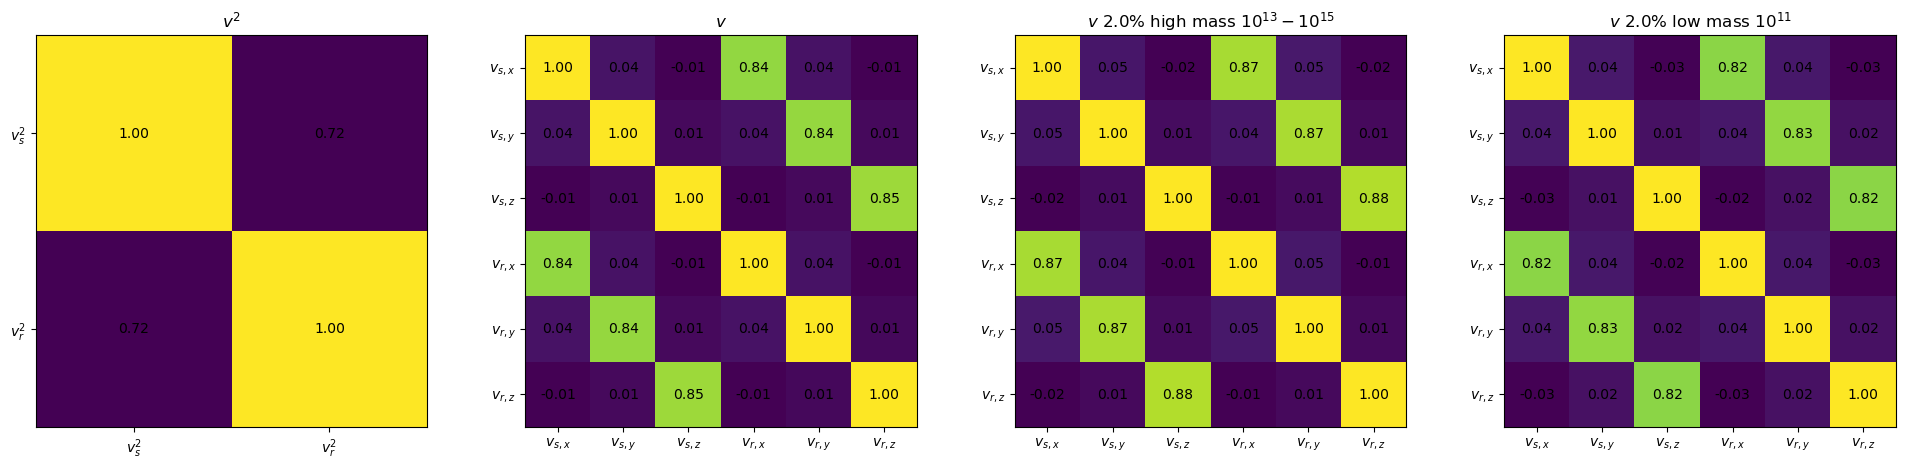

In [30]:
fig, ax = plt.subplots(1, 4, facecolor="white", dpi=100, figsize=(24,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)

corr = np.corrcoef(vtot_simu, vtot_schmit, rowvar=False)
pcm = ax[0].imshow(corr, cmap=cm.viridis)
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, "%.2f"%corr[i, j], ha="center", va="center")
# fig.colorbar(pcm, ax=ax[0], extend='both')
ax[0].set_xticks(range(2)); ax[0].set_yticks(range(2))
ax[0].set_xticklabels(["$v^2_{s}$", "$v^2_{r}$"])
ax[0].set_yticklabels(["$v^2_{s}$", "$v^2_{r}$"])
ax[0].set_title("$v^2$")

corr = np.corrcoef(hdisp, schmit_output["vel"], rowvar=False)
pcm = ax[1].imshow(corr, cmap=cm.viridis)
for i in range(6):
    for j in range(6):
        ax[1].text(j, i, "%.2f"%corr[i, j], ha="center", va="center")
# fig.colorbar(pcm, ax=ax[0], extend='both')
ax[1].set_xticks(range(6)); ax[1].set_yticks(range(6))
ax[1].set_xticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[1].set_yticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[1].set_title("$v$")

rate = 0.02
corr = np.corrcoef(hdisp[0:int(rate * len(hdisp))], schmit_output["vel"][0:int(rate * len(hdisp))], rowvar=False)
pcm = ax[2].imshow(corr, cmap=cm.viridis)
for i in range(6):
    for j in range(6):
        ax[2].text(j, i, "%.2f"%corr[i, j], ha="center", va="center")
# fig.colorbar(pcm, ax=ax[1], extend='both')
ax[2].set_xticks(range(6)); ax[2].set_yticks(range(6))
ax[2].set_xticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[2].set_yticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[2].set_title(f"$v$ {rate * 100}% high mass $10^{{13}}-10^{{15}}$")

rate = 0.98
corr = np.corrcoef(hdisp[int(rate * len(hdisp)):], schmit_output["vel"][int(rate * len(hdisp)):], rowvar=False)
pcm = ax[3].imshow(corr, cmap=cm.viridis)
for i in range(6):
    for j in range(6):
        ax[3].text(j, i, "%.2f"%corr[i, j], ha="center", va="center")
# fig.colorbar(pcm, ax=ax[2], extend='both')
ax[3].set_xticks(range(6)); ax[3].set_yticks(range(6))
ax[3].set_xticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[3].set_yticklabels(["$v_{s,x}$", "$v_{s,y}$", "$v_{s,z}$", "$v_{r,x}$", "$v_{r,y}$", "$v_{r,z}$"])
ax[3].set_title(f"$v$ {100 - rate * 100}% low mass $10^{{11}}$")

In [31]:
g_5["GroupLen"][int(0.98 * len(hdisp)):] * 2.7754e11 * 0.308 * 600**3 / 1024**3 

array([[3.43922174e+11],
       [3.43922174e+11],
       [3.43922174e+11],
       ...,
       [3.43922174e+11],
       [3.43922174e+11],
       [3.43922174e+11]])

In [32]:
schmit_modified_2 = copy.deepcopy(schmit_output["vel"])
if int(rate_upper * len(schmit_output["vel"])) > int(rate_lower * len(schmit_output["vel"])):
    raise "Exist Duplicate Element"
schmit_modified_2[0:int(rate_upper * len(schmit_output["vel"]))] = schmit_output["vel"][0:int(rate_upper * len(schmit_output["vel"]))] / beta_upper
schmit_modified_2[int(rate_lower * len(schmit_output["vel"])):] = schmit_output["vel"][int(rate_lower * len(schmit_output["vel"])):] / beta_lower

displacement.WriteDTFE("/home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_2_005_g0512", Nall=len(schmit_output["vel"]), BoxSize=600., pos=g_5["GroupPos"] - schmit_modified_2, vel=schmit_modified_2)

In [33]:
displacement.WriteDTFE("/home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_005_g0512", Nall=len(hpos), BoxSize=600., pos=g_5["GroupPos"] - schmit_output["vel"] / beta_all[0], vel=schmit_output["vel"] / beta_all[0])

displacement.WriteDTFE("/home/zhanglf/data/DTFE_Input/grpschmitoutputall_lsq_modified_005_g0512", Nall=len(hpos), BoxSize=600., pos=g_5["GroupPos"] - schmit_output["vel"] / beta_all_lsq, vel=schmit_output["vel"] / beta_all_lsq)

#### 速度场功率谱

对于通过重构方法得到的场与位移，需要通过DTFE插值到标准网格上后，计算速度散度的负数，才能够与数值模拟中的密度场进行互关联

对于位移场，可以将矢量场分为$v_x, v_y, v_z$分别计算功率谱，相加后得到矢量场的功率谱与互相关系数

##### DTFE 计算

In [34]:
exec = file_edit.DTFE(DTFE_path="/home/zhanglf/library/DTFE_1.1.1/bin/DTFE",\
                        inputFile="/home/zhanglf/data/DTFE_Input/grpschmitoutputall_005_g0512",\
                        outputFile="/home/zhanglf/data/DTFE_Output/grpschmitoutputall_005_g0512")
exec.set_field(denFlag=True, velFlag=True, gradFlag=False, divFlag=True, vorFlag=False, pFlag=True, grid=512, MpcUnit=1)
exec.execute(shellFlag=True)

Command to be executed: 
/home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_005_g0512 -p --field density_a velocity_a  divergence_a  --grid 512 --MpcUnit 1

RUNNING: /home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_005_g0512 -p --field density_a velocity_a divergence_a --grid 512 --MpcUnit 1 

The program will interpolate to grid the chosen field using the DTFE method with the following input parameters:
	 unaveraged field(s)    : none
	 averaged field(s)      :  density, velocity, velocity divergence,
	 interpolation method   : DTFE
	 input data file        : /home/zhanglf/data/DTFE_Input/grpschmitoutputall_005_g0512
	 output file            : /home/zhanglf/data/DTFE_Output/grpschmitoutputall_005_g0512
	 grid size              : 512  512  512   for the full particle box
	 computing the 

In [35]:
displacement.WriteDTFE("/home/zhanglf/data/DTFE_Input/grpsimuoutputall_005_g0512", Nall=len(hpos), BoxSize=600., pos=hpos, vel=hdisp)

In [36]:
exec = file_edit.DTFE(DTFE_path="/home/zhanglf/library/DTFE_1.1.1/bin/DTFE",\
                        inputFile="/home/zhanglf/data/DTFE_Input/grpsimuoutputall_005_g0512",\
                        outputFile="/home/zhanglf/data/DTFE_Output/grpsimuoutputall_005_g0512")
exec.set_field(denFlag=True, velFlag=True, gradFlag=False, divFlag=True, vorFlag=False, pFlag=True, grid=512, MpcUnit=1)
exec.execute(shellFlag=True)

Command to be executed: 
/home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpsimuoutputall_005_g0512 /home/zhanglf/data/DTFE_Output/grpsimuoutputall_005_g0512 -p --field density_a velocity_a  divergence_a  --grid 512 --MpcUnit 1

RUNNING: /home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpsimuoutputall_005_g0512 /home/zhanglf/data/DTFE_Output/grpsimuoutputall_005_g0512 -p --field density_a velocity_a divergence_a --grid 512 --MpcUnit 1 

The program will interpolate to grid the chosen field using the DTFE method with the following input parameters:
	 unaveraged field(s)    : none
	 averaged field(s)      :  density, velocity, velocity divergence,
	 interpolation method   : DTFE
	 input data file        : /home/zhanglf/data/DTFE_Input/grpsimuoutputall_005_g0512
	 output file            : /home/zhanglf/data/DTFE_Output/grpsimuoutputall_005_g0512
	 grid size              : 512  512  512   for the full particle box
	 computing the grid interpo

In [37]:
exec = file_edit.DTFE(DTFE_path="/home/zhanglf/library/DTFE_1.1.1/bin/DTFE",\
                        inputFile="/home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_005_g0512",\
                        outputFile="/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_005_g0512")
exec.set_field(denFlag=True, velFlag=True, gradFlag=False, divFlag=True, vorFlag=False, pFlag=True, grid=512, MpcUnit=1)
exec.execute(shellFlag=True)

exec = file_edit.DTFE(DTFE_path="/home/zhanglf/library/DTFE_1.1.1/bin/DTFE",\
                        inputFile="/home/zhanglf/data/DTFE_Input/grpschmitoutputall_lsq_modified_005_g0512",\
                        outputFile="/home/zhanglf/data/DTFE_Output/grpschmitoutputall_lsq_modified_005_g0512")
exec.set_field(denFlag=True, velFlag=True, gradFlag=False, divFlag=True, vorFlag=False, pFlag=True, grid=512, MpcUnit=1)
exec.execute(shellFlag=True)

Command to be executed: 
/home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_005_g0512 -p --field density_a velocity_a  divergence_a  --grid 512 --MpcUnit 1

RUNNING: /home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_005_g0512 -p --field density_a velocity_a divergence_a --grid 512 --MpcUnit 1 

The program will interpolate to grid the chosen field using the DTFE method with the following input parameters:
	 unaveraged field(s)    : none
	 averaged field(s)      :  density, velocity, velocity divergence,
	 interpolation method   : DTFE
	 input data file        : /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_005_g0512
	 output file            : /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_005_g0512
	 grid size              : 512 

In [38]:
exec = file_edit.DTFE(DTFE_path="/home/zhanglf/library/DTFE_1.1.1/bin/DTFE",\
                        inputFile="/home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_2_005_g0512",\
                        outputFile="/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_2_005_g0512")
exec.set_field(denFlag=True, velFlag=True, gradFlag=False, divFlag=True, vorFlag=False, pFlag=True, grid=512, MpcUnit=1)
exec.execute(shellFlag=True)

Command to be executed: 
/home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_2_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_2_005_g0512 -p --field density_a velocity_a  divergence_a  --grid 512 --MpcUnit 1

RUNNING: /home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_2_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_2_005_g0512 -p --field density_a velocity_a divergence_a --grid 512 --MpcUnit 1 

The program will interpolate to grid the chosen field using the DTFE method with the following input parameters:
	 unaveraged field(s)    : none
	 averaged field(s)      :  density, velocity, velocity divergence,
	 interpolation method   : DTFE
	 input data file        : /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_2_005_g0512
	 output file            : /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_2_005_g0512
	 grid size        

In [39]:
exec = file_edit.DTFE(DTFE_path="/home/zhanglf/library/DTFE_1.1.1/bin/DTFE",\
                        inputFile="/home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_linear_005_g0512",\
                        outputFile="/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_linear_005_g0512")
exec.set_field(denFlag=False, velFlag=True, gradFlag=False, divFlag=True, vorFlag=False, pFlag=True, grid=512, MpcUnit=1)
exec.execute(shellFlag=True)

Command to be executed: 
/home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_linear_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_linear_005_g0512 -p --field  velocity_a  divergence_a  --grid 512 --MpcUnit 1

RUNNING: /home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_linear_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_linear_005_g0512 -p --field velocity_a divergence_a --grid 512 --MpcUnit 1 

The program will interpolate to grid the chosen field using the DTFE method with the following input parameters:
	 unaveraged field(s)    : none
	 averaged field(s)      :  velocity, velocity divergence,
	 interpolation method   : DTFE
	 input data file        : /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_linear_005_g0512
	 output file            : /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_linear_005_g0512
	 grid size      

In [40]:
exec = file_edit.DTFE(DTFE_path="/home/zhanglf/library/DTFE_1.1.1/bin/DTFE",\
                        inputFile="/home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_specific_005_g0512",\
                        outputFile="/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_specific_005_g0512")
exec.set_field(denFlag=False, velFlag=True, gradFlag=False, divFlag=True, vorFlag=False, pFlag=True, grid=512, MpcUnit=1)
exec.execute(shellFlag=True)

Command to be executed: 
/home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_specific_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_specific_005_g0512 -p --field  velocity_a  divergence_a  --grid 512 --MpcUnit 1

RUNNING: /home/zhanglf/library/DTFE_1.1.1/bin/DTFE /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_specific_005_g0512 /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_specific_005_g0512 -p --field velocity_a divergence_a --grid 512 --MpcUnit 1 

The program will interpolate to grid the chosen field using the DTFE method with the following input parameters:
	 unaveraged field(s)    : none
	 averaged field(s)      :  velocity, velocity divergence,
	 interpolation method   : DTFE
	 input data file        : /home/zhanglf/data/DTFE_Input/grpschmitoutputall_modified_specific_005_g0512
	 output file            : /home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_specific_005_g0512
	 gri

#### CIC计算密度场

In [41]:
cat_simu_pos = nbodykit.source.catalog.ArrayCatalog({'Position': hpos})
mesh_simu_pos_cic = cat_simu_pos.to_mesh(resampler='cic', Nmesh=512, compensated=True, interlaced=True, BoxSize=600.)
Pk_simu_delta_cic = nbodykit.algorithms.FFTPower(mesh_simu_pos_cic, mode='1d').power
del cat_simu_pos
gc.collect()

0

In [42]:
cat_schmit_pos = nbodykit.source.catalog.ArrayCatalog({'Position': schmit_output["pos"]})
mesh_schmit_pos_cic = cat_schmit_pos.to_mesh(resampler='cic', Nmesh=512, compensated=True, interlaced=True, BoxSize=600.)
Pk_schmit_delta_cic = nbodykit.algorithms.FFTPower(mesh_schmit_pos_cic, mode='1d').power
del cat_schmit_pos
gc.collect()

0

In [43]:
cat_schmit_modified_pos = nbodykit.source.catalog.ArrayCatalog({'Position': g_5["GroupPos"] - schmit_output["vel"] / beta_all[0]})
mesh_schmit_modified_pos_cic = cat_schmit_modified_pos.to_mesh(resampler='cic', Nmesh=512, compensated=True, interlaced=True, BoxSize=600.)
Pk_schmit_modified_delta_cic = nbodykit.algorithms.FFTPower(mesh_schmit_modified_pos_cic, mode='1d').power
del cat_schmit_modified_pos
gc.collect()

0

#### 读取DTFE数据

In [44]:
grid = 512
# vel_simu_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpsimuoutputall_005_g0512.a_vel", dtype=np.float32).reshape((grid,grid,grid,3), order='C')
velDiv_simu_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpsimuoutputall_005_g0512.a_velDiv", dtype=np.float32).reshape((grid,grid,grid), order='C')

In [45]:
grid = 512
# vel_schmit_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_005_g0512.a_vel", dtype=np.float32).reshape((grid,grid,grid,3), order='C')
velDiv_schmit_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_005_g0512.a_velDiv", dtype=np.float32).reshape((grid,grid,grid), order='C')

In [46]:
grid = 512
# vel_schmit_modified_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_005_g0512.a_vel", dtype=np.float32).reshape((grid,grid,grid,3), order='C')
velDiv_schmit_modified_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_005_g0512.a_velDiv", dtype=np.float32).reshape((grid,grid,grid), order='C')

velDiv_schmit_lsq_modified_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_lsq_modified_005_g0512.a_velDiv", dtype=np.float32).reshape((grid,grid,grid), order='C')

In [47]:
grid = 512
# vel_schmit_modified_2_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_2_005_g0512.a_vel", dtype=np.float32).reshape((grid,grid,grid,3), order='C')
velDiv_schmit_modified_2_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_2_005_g0512.a_velDiv", dtype=np.float32).reshape((grid,grid,grid), order='C')

In [48]:
grid = 512
# vel_schmit_modified_linear_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpsimuoutputall_modified_linear_005_g0512.a_vel", dtype=np.float32).reshape((grid,grid,grid,3), order='C')
velDiv_schmit_modified_linear_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_linear_005_g0512.a_velDiv", dtype=np.float32).reshape((grid,grid,grid), order='C')

In [49]:
grid = 512
# vel_schmit_modified_linear_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpsimuoutputall_modified_linear_005_g0512.a_vel", dtype=np.float32).reshape((grid,grid,grid,3), order='C')
velDiv_schmit_modified_specific_DTFE = np.fromfile("/home/zhanglf/data/DTFE_Output/grpschmitoutputall_modified_specific_005_g0512.a_velDiv", dtype=np.float32).reshape((grid,grid,grid), order='C')

In [50]:
grid = 512
delta_init = np.fromfile("/home/zhanglf/data/init0512.bin", dtype=np.float32).reshape((grid,grid,grid), order='F')

#### 检验密度场

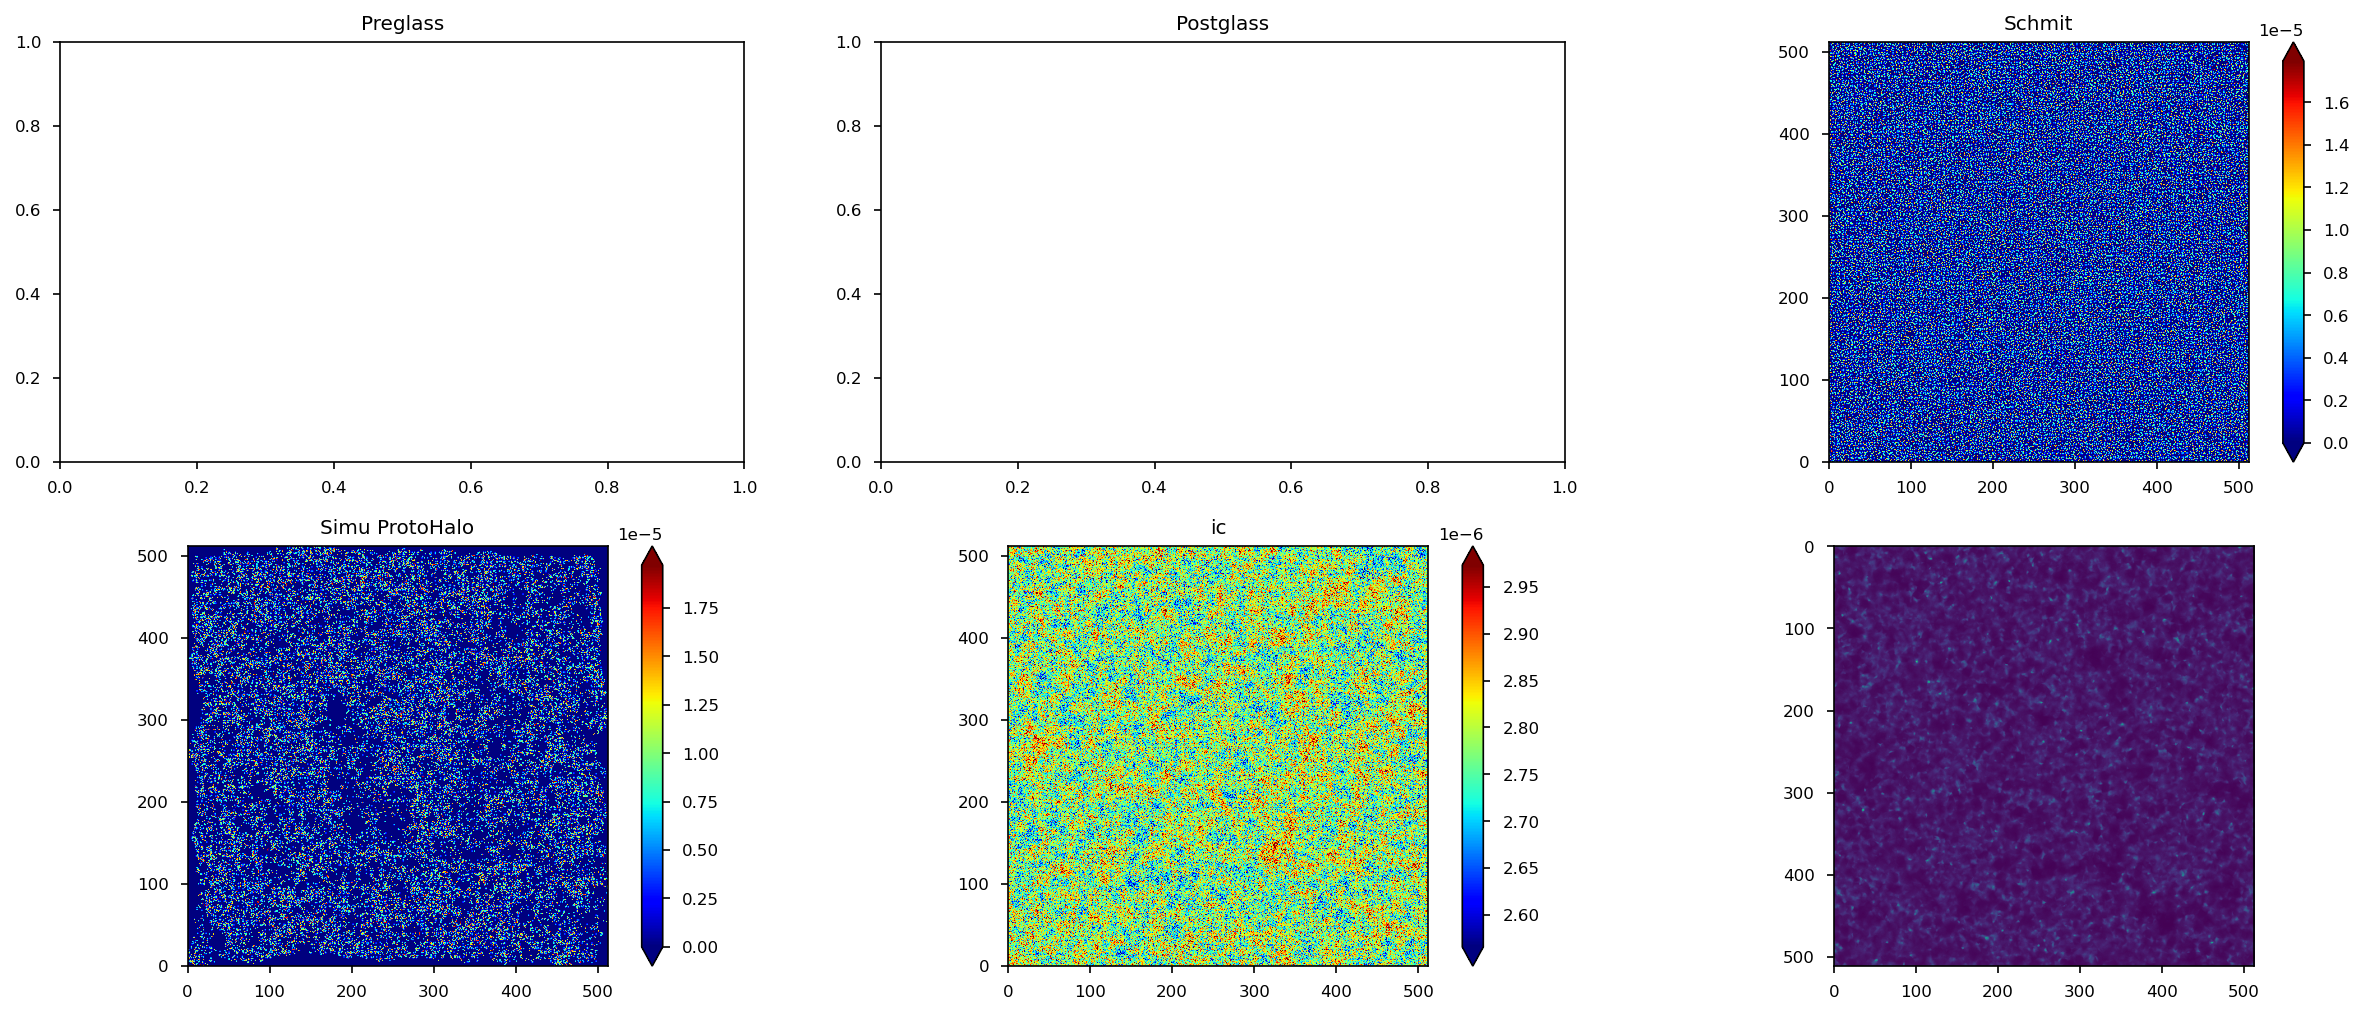

In [48]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(2, 3, facecolor="white", dpi=150, figsize=(20,8))
    myMatplotlibPlot.Show2dSlice(preglass["pos"], 0, 10, fig=fig, axes=ax[0,0], upper=95, lower=5)
    ax[0,0].set_title("Preglass")
    myMatplotlibPlot.Show2dSlice(postglass["pos"], 0, 10, fig=fig, axes=ax[0,1], upper=95, lower=5)
    ax[0,1].set_title("Postglass")
    myMatplotlibPlot.Show2dSlice(schmit_output["pos"], 0, 10, fig=fig, axes=ax[0,2], upper=95, lower=5)
    ax[0,2].set_title("Schmit")
    myMatplotlibPlot.Show2dSlice(hpos, 0, 10, fig=fig, axes=ax[1,0], upper=95, lower=5)
    ax[1,0].set_title("Simu ProtoHalo")
    myMatplotlibPlot.Show2dSlice(ic["pos"], 0, 10, fig=fig, axes=ax[1,1], upper=95, lower=5)
    ax[1,1].set_title("ic")
    # ax[1,2].imshow(den_simu_DTFE[:,:,0])

In [39]:
tmp_preglass_pos = preglass["pos"][(preglass["pos"][:, 0] > 0) & (preglass["pos"][:, 0] < 20) & (preglass["pos"][:, 1] > 0) & (preglass["pos"][:, 1] < 20) & (preglass["pos"][:, 2] > 0) & (preglass["pos"][:, 2] < 10)]

tmp_postglass_pos = postglass["pos"][(postglass["pos"][:, 0] > 0) & (postglass["pos"][:, 0] < 20) & (postglass["pos"][:, 1] > 0) & (postglass["pos"][:, 1] < 20) & (postglass["pos"][:, 2] > 0) & (postglass["pos"][:, 2] < 10)]

tmp_ic_pos = ic["pos"][(ic["pos"][:, 0] > 0) & (ic["pos"][:, 0] < 20) & (ic["pos"][:, 1] > 0) & (ic["pos"][:, 1] < 20) & (ic["pos"][:, 2] > 0) & (ic["pos"][:, 2] < 10)]

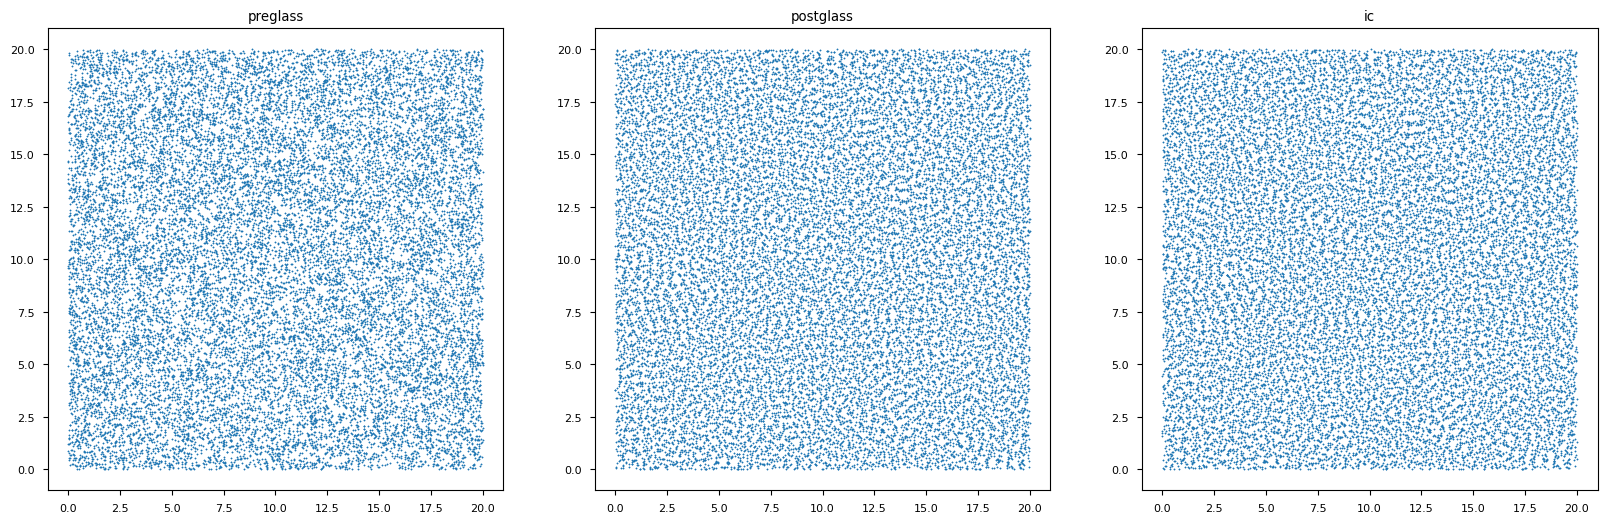

In [40]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, 3, facecolor="white", dpi=100, figsize=(20,6))
    
    ax[0].scatter(tmp_preglass_pos[:, 0], tmp_preglass_pos[:, 1], s=1)
    ax[0].set_title("preglass")
    ax[1].scatter(tmp_postglass_pos[:, 0], tmp_postglass_pos[:, 1], s=1)
    ax[1].set_title("postglass")
    ax[2].scatter(tmp_ic_pos[:, 0], tmp_ic_pos[:, 1], s=1)
    ax[2].set_title("ic")

#### 计算功率谱

In [51]:
def FFTPower_ArrayMesh_DTFE(Field1, BoxSize, second=None):
    if second is not None:
        # The second parameter is not None
        if (Field1.shape != second.shape):
            raise ValueError("Two Fields must have the same shape")
    else:
        second = Field1
    try:
        ndim = Field1.shape[-1]
        for i in range(ndim):
            mesh_1 = nbodykit.lab.ArrayMesh(Field1[:,:,:,i], BoxSize=BoxSize)
            mesh_2 = nbodykit.lab.ArrayMesh(second[:,:,:,i], BoxSize=BoxSize)
            if i == 0:
                Pk = nbodykit.algorithms.FFTPower(mesh_1, second=mesh_2, mode='1d').power
            else:
                Pk["power"] = Pk["power"] + nbodykit.algorithms.FFTPower(mesh_1, second=mesh_2, mode='1d').power["power"] #type: ignore
    except:
        mesh_1 = nbodykit.lab.ArrayMesh(Field1, BoxSize=BoxSize)
        mesh_2 = nbodykit.lab.ArrayMesh(second, BoxSize=BoxSize)
        Pk = nbodykit.algorithms.FFTPower(mesh_1, second=mesh_2, mode='1d').power
    return Pk

In [52]:
Pk_simu_schmit_deltadelta_cic = nbodykit.algorithms.FFTPower(mesh_simu_pos_cic, second=mesh_schmit_pos_cic, mode="1d", BoxSize=600.).power
Pk_simu_schmit_modified_deltadelta_cic = nbodykit.algorithms.FFTPower(mesh_simu_pos_cic, second=mesh_schmit_modified_pos_cic, mode="1d", BoxSize=600.).power
# Pk_simu_schmit_velvel_DTFE = FFTPower_ArrayMesh_DTFE(vel_simu_DTFE, second=vel_schmit_DTFE, BoxSize=600.)
# Pk_simu_simu_deltaMveldiv_DTFE = FFTPower_ArrayMesh_DTFE(den_simu_DTFE / np.mean(den_simu_DTFE) - 1, second=-velDiv_simu_DTFE, BoxSize=600.)
# Pk_schmit_schmit_deltaMveldiv_DTFE = FFTPower_ArrayMesh_DTFE(den_schmit_DTFE / np.mean(den_schmit_DTFE) - 1, second=-velDiv_schmit_DTFE, BoxSize=600.)
# Pk_simu_init0512_deltadelta_DTFE = FFTPower_ArrayMesh_DTFE(den_simu_DTFE / np.mean(den_simu_DTFE) - 1, second=delta_init_DTFE, BoxSize=600.)
# Pk_schmit_init0512_deltadelta_DTFE = FFTPower_ArrayMesh_DTFE(den_schmit_DTFE / np.mean(den_schmit_DTFE) - 1, second=delta_init_DTFE, BoxSize=600.)
# Pk_simu_init0512_deltadelta_DTFE_2 = FFTPower_ArrayMesh_DTFE(den_simu_DTFE / np.mean(den_simu_DTFE) - 1, second=den_init_DTFE, BoxSize=600.)
# Pk_schmit_init0512_deltadelta_DTFE_2 = FFTPower_ArrayMesh_DTFE(den_schmit_DTFE / np.mean(den_schmit_DTFE) - 1, second=den_init_DTFE, BoxSize=600.)
# Pk_schmit_modified_init0512_deltadelta_DTFE = FFTPower_ArrayMesh_DTFE(den_schmit_modified_DTFE / np.mean(den_schmit_modified_DTFE) - 1, second=delta_init_DTFE, BoxSize=600.)
Pk_simu_init0512_Mveldivdelta_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_simu_DTFE, second=delta_init, BoxSize=600.)
Pk_schmit_init0512_Mveldivdelta_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_DTFE, second=delta_init, BoxSize=600.)
Pk_schmit_modified_init0512_Mveldivdelta_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_modified_DTFE, second=delta_init, BoxSize=600.)
Pk_schmit_lsq_modified_init0512_Mveldivdelta_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_lsq_modified_DTFE, second=delta_init, BoxSize=600.)
# Pk_schmit_modified_2_init0512_deltadelta_DTFE = FFTPower_ArrayMesh_DTFE(den_schmit_modified_2_DTFE / np.mean(den_schmit_modified_2_DTFE) - 1, second=delta_init_DTFE, BoxSize=600.)
Pk_schmit_modified_2_init0512_Mveldivdelta_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_modified_2_DTFE, second=delta_init, BoxSize=600.)
Pk_schmit_modified_linear_init0512_Mveldivdelta_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_modified_linear_DTFE, second=delta_init, BoxSize=600.)
Pk_schmit_modified_specific_init0512_Mveldivdelta_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_modified_specific_DTFE, second=delta_init, BoxSize=600.)

# Pk_simu_delta_DTFE = FFTPower_ArrayMesh_DTFE(den_simu_DTFE / np.mean(den_simu_DTFE) - 1, BoxSize=600.)
# Pk_schmit_delta_DTFE = FFTPower_ArrayMesh_DTFE(den_schmit_DTFE / np.mean(den_schmit_DTFE) - 1, BoxSize=600.)
# Pk_schmit_modified_delta_DTFE = FFTPower_ArrayMesh_DTFE(den_schmit_modified_DTFE / np.mean(den_schmit_modified_DTFE) - 1, BoxSize=600.)
# Pk_schmit_modified_2_delta_DTFE = FFTPower_ArrayMesh_DTFE(den_schmit_modified_2_DTFE / np.mean(den_schmit_modified_2_DTFE) - 1, BoxSize=600.)
# Pk_simu_vel_DTFE = FFTPower_ArrayMesh_DTFE(vel_simu_DTFE, BoxSize=600.)
# Pk_schmit_vel_DTFE = FFTPower_ArrayMesh_DTFE(vel_schmit_DTFE, BoxSize=600.)
Pk_simu_Mveldiv_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_simu_DTFE, BoxSize=600.)
Pk_schmit_Mveldiv_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_DTFE, BoxSize=600.)
Pk_schmit_modified_Mveldiv_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_modified_DTFE, BoxSize=600.)
Pk_schmit_lsq_modified_Mveldiv_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_lsq_modified_DTFE, BoxSize=600.)
Pk_schmit_modified_2_Mveldiv_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_modified_2_DTFE, BoxSize=600.)
Pk_schmit_modified_linear_Mveldiv_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_modified_linear_DTFE, BoxSize=600.)
Pk_schmit_modified_specific_Mveldiv_DTFE = FFTPower_ArrayMesh_DTFE(-velDiv_schmit_modified_specific_DTFE, BoxSize=600.)
Pk_init0512_delta = FFTPower_ArrayMesh_DTFE(delta_init, BoxSize=600.)
# Pk_init0512_delta_DTFE_2 = FFTPower_ArrayMesh_DTFE(den_init_DTFE, BoxSize=600.)

corr_simu_schmit_deltadelta_cic = (Pk_simu_schmit_deltadelta_cic['power'].real) / np.sqrt((Pk_simu_delta_cic['power'].real) * (Pk_schmit_delta_cic['power'].real))
corr_simu_schmit_modified_deltadelta_cic = (Pk_simu_schmit_modified_deltadelta_cic['power'].real) / np.sqrt((Pk_simu_delta_cic['power'].real) * (Pk_schmit_modified_delta_cic['power'].real))
# corr_simu_init0512_deltadelta_DTFE = (Pk_simu_init0512_deltadelta_DTFE['power'].real) / np.sqrt((Pk_simu_delta_DTFE['power'].real) * (Pk_init0512_delta_DTFE['power'].real))
# corr_schmit_init0512_deltadelta_DTFE = (Pk_schmit_init0512_deltadelta_DTFE['power'].real) / np.sqrt((Pk_schmit_delta_DTFE['power'].real) * (Pk_init0512_delta_DTFE['power'].real))
# corr_simu_simu_deltaMveldiv_DTFE = (Pk_simu_simu_deltaMveldiv_DTFE['power'].real) / np.sqrt((Pk_simu_delta_DTFE['power'].real) * (Pk_simu_Mveldiv_DTFE['power'].real))
# corr_schmit_schmit_deltaMveldiv_DTFE = (Pk_schmit_schmit_deltaMveldiv_DTFE['power'].real) / np.sqrt((Pk_schmit_delta_DTFE['power'].real) * (Pk_schmit_Mveldiv_DTFE['power'].real))
# corr_schmit_modified_init0512_deltadelta_DTFE = (Pk_schmit_modified_init0512_deltadelta_DTFE['power'].real) / np.sqrt((Pk_schmit_modified_delta_DTFE['power'].real) * (Pk_init0512_delta_DTFE['power'].real))
corr_simu_init0512_Mveldivdelta_DTFE = (Pk_simu_init0512_Mveldivdelta_DTFE['power'].real) / np.sqrt((Pk_simu_Mveldiv_DTFE['power'].real) * (Pk_init0512_delta['power'].real))
corr_schmit_init0512_Mveldivdelta_DTFE = (Pk_schmit_init0512_Mveldivdelta_DTFE['power'].real) / np.sqrt((Pk_schmit_Mveldiv_DTFE['power'].real) * (Pk_init0512_delta['power'].real))
corr_schmit_modified_init0512_Mveldivdelta_DTFE = (Pk_schmit_modified_init0512_Mveldivdelta_DTFE['power'].real) / np.sqrt((Pk_schmit_modified_Mveldiv_DTFE['power'].real) * (Pk_init0512_delta['power'].real))
corr_schmit_lsq_modified_init0512_Mveldivdelta_DTFE = (Pk_schmit_lsq_modified_init0512_Mveldivdelta_DTFE['power'].real) / np.sqrt((Pk_schmit_lsq_modified_Mveldiv_DTFE['power'].real) * (Pk_init0512_delta['power'].real))
# corr_schmit_modified_2_init0512_deltadelta_DTFE = (Pk_schmit_modified_2_init0512_deltadelta_DTFE['power'].real) / np.sqrt((Pk_schmit_modified_2_delta_DTFE['power'].real) * (Pk_init0512_delta_DTFE['power'].real))
corr_schmit_modified_2_init0512_Mveldivdelta_DTFE = (Pk_schmit_modified_2_init0512_Mveldivdelta_DTFE['power'].real) / np.sqrt((Pk_schmit_modified_2_Mveldiv_DTFE['power'].real) * (Pk_init0512_delta['power'].real))
corr_schmit_modified_linear_init0512_Mveldivdelta_DTFE = (Pk_schmit_modified_linear_init0512_Mveldivdelta_DTFE['power'].real) / np.sqrt((Pk_schmit_modified_linear_Mveldiv_DTFE['power'].real) * (Pk_init0512_delta['power'].real))
corr_schmit_modified_specific_init0512_Mveldivdelta_DTFE = (Pk_schmit_modified_specific_init0512_Mveldivdelta_DTFE['power'].real) / np.sqrt((Pk_schmit_modified_specific_Mveldiv_DTFE['power'].real) * (Pk_init0512_delta['power'].real))
# corr_simu_init0512_deltadelta_DTFE_2 = (Pk_simu_init0512_deltadelta_DTFE_2['power'].real) / np.sqrt((Pk_simu_delta_DTFE['power'].real) * (Pk_init0512_delta_DTFE_2['power'].real))
# corr_schmit_init0512_deltadelta_DTFE_2 = (Pk_schmit_init0512_deltadelta_DTFE_2['power'].real) / np.sqrt((Pk_schmit_delta_DTFE['power'].real) * (Pk_init0512_delta_DTFE_2['power'].real))

/tmp/ipykernel_1190052/3212071346.py:36: RuntimeWarning: invalid value encountered in true_divide
  corr_simu_schmit_deltadelta_cic = (Pk_simu_schmit_deltadelta_cic['power'].real) / np.sqrt((Pk_simu_delta_cic['power'].real) * (Pk_schmit_delta_cic['power'].real))
/tmp/ipykernel_1190052/3212071346.py:37: RuntimeWarning: invalid value encountered in true_divide
  corr_simu_schmit_modified_deltadelta_cic = (Pk_simu_schmit_modified_deltadelta_cic['power'].real) / np.sqrt((Pk_simu_delta_cic['power'].real) * (Pk_schmit_modified_delta_cic['power'].real))
/tmp/ipykernel_1190052/3212071346.py:43: RuntimeWarning: invalid value encountered in true_divide
  corr_simu_init0512_Mveldivdelta_DTFE = (Pk_simu_init0512_Mveldivdelta_DTFE['power'].real) / np.sqrt((Pk_simu_Mveldiv_DTFE['power'].real) * (Pk_init0512_delta['power'].real))
/tmp/ipykernel_1190052/3212071346.py:44: RuntimeWarning: invalid value encountered in true_divide
  corr_schmit_init0512_Mveldivdelta_DTFE = (Pk_schmit_init0512_Mveldivdelta

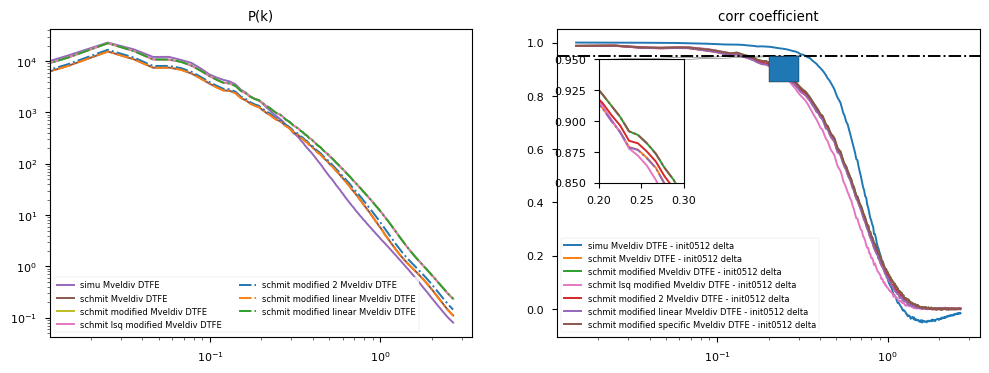

In [53]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, 2, facecolor="white", dpi=100, figsize=(12,4))
    # ax[0].plot(Pk_simu_delta_DTFE['k'], Pk_simu_delta_DTFE["power"].real, PlotParams.colors["default"][0], label="simu delta DTFE")
    # ax[0].plot(Pk_simu_delta_cic['k'], Pk_simu_delta_cic["power"].real, PlotParams.colors["default"][0], label="simu delta cic")
    # ax[0].plot(Pk_schmit_delta_DTFE['k'], Pk_schmit_delta_DTFE["power"].real, PlotParams.colors["default"][1], label="schmit denlta DTFE")
    # ax[0].plot(Pk_schmit_delta_cic['k'], Pk_schmit_delta_cic["power"].real, PlotParams.colors["default"][1], label="schmit delta cic")
    # ax[0].plot(Pk_simu_pos['k'], Pk_simu_pos["power"].real, PlotParams.colors["default"][0], label="simu cic")
    # ax[0].plot(Pk_schmit_pos['k'], Pk_schmit_pos["power"].real, PlotParams.colors["default"][1], label="!schmit cic")
    # ax[0].plot(Pk_simu_vel_DTFE['k'], Pk_simu_vel_DTFE["power"].real, PlotParams.colors["default"][2], label="simu vel DTFE")
    # ax[0].plot(Pk_schmit_vel_DTFE['k'], Pk_schmit_vel_DTFE["power"].real, PlotParams.colors["default"][3], label="schmit vel DTFE")
    # ax[0].plot(Pk_simu_velX_DTFE['k'], Pk_simu_velX_DTFE["power"].real, PlotParams.colors["default"][2], label="simu velX DTFE")
    # ax[0].plot(Pk_schmit_velX_DTFE['k'], Pk_schmit_velX_DTFE["power"].real, PlotParams.colors["default"][3], label="schmit velX DTFE")
    ax[0].plot(Pk_simu_Mveldiv_DTFE['k'], Pk_simu_Mveldiv_DTFE["power"].real, PlotParams.colors["default"][4], label="simu Mveldiv DTFE")
    ax[0].plot(Pk_schmit_Mveldiv_DTFE['k'], Pk_schmit_Mveldiv_DTFE["power"].real, PlotParams.colors["default"][5], label="schmit Mveldiv DTFE")
    # ax[0].plot(Pk_init0512_delta['k'], Pk_init0512_delta["power"].real, PlotParams.colors["default"][6], label="init0512")
    # ax[0].plot(Pk_preglass_pos['k'], Pk_preglass_pos["power"].real, PlotParams.colors["default"][7], label="preglass cic")
    # ax[0].plot(Pk_postglass_pos['k'], Pk_postglass_pos["power"].real, PlotParams.colors["default"][8], label="postglass cic")
    # ax[0].plot(Pk_schmit_modified_delta_DTFE['k'], Pk_schmit_modified_delta_DTFE["power"].real, PlotParams.colors["default"][7], label="schmit modified delta DTFE")
    ax[0].plot(Pk_schmit_modified_Mveldiv_DTFE['k'], Pk_schmit_modified_Mveldiv_DTFE["power"].real, PlotParams.colors["default"][8], label="schmit modified Mveldiv DTFE")
    ax[0].plot(Pk_schmit_lsq_modified_Mveldiv_DTFE['k'], Pk_schmit_modified_Mveldiv_DTFE["power"].real, PlotParams.colors["default"][6], label="schmit lsq modified Mveldiv DTFE")
    # ax[0].plot(Pk_schmit_modified_2_delta_DTFE['k'], Pk_schmit_modified_2_delta_DTFE["power"].real, PlotParams.colors["default"][9], label="schmit modified 2 delta DTFE")
    ax[0].plot(Pk_schmit_modified_2_Mveldiv_DTFE['k'], Pk_schmit_modified_2_Mveldiv_DTFE["power"].real, PlotParams.colors["default"][0], label="schmit modified 2 Mveldiv DTFE", linestyle='-.')
    ax[0].plot(Pk_schmit_modified_linear_Mveldiv_DTFE['k'], Pk_schmit_modified_linear_Mveldiv_DTFE["power"].real, PlotParams.colors["default"][1], label="schmit modified linear Mveldiv DTFE", linestyle='-.')
    ax[0].plot(Pk_schmit_modified_specific_Mveldiv_DTFE['k'], Pk_schmit_modified_specific_Mveldiv_DTFE["power"].real, PlotParams.colors["default"][2], label="schmit modified linear Mveldiv DTFE", linestyle='-.')

    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].legend(ncol = 2, fontsize=6)
    ax[0].set_title("P(k)")
    # ax[0].set_ylim(500, 3*1e4)
    
    # ax[1].plot(Pk_simu_schmit_velvel_DTFE['k'], corr_simu_schmit_velvel_DTFE, PlotParams.colors["default"][0], label="simu vel DTFE - schmit vel DTFE")
    # ax[1].plot(Pk_simu_schmit_deltadelta_DTFE['k'], corr_simu_schmit_deltadelta_DTFE, PlotParams.colors["default"][1], label="simu delta DTFE - schmit delta DTFE")
    # ax[1].plot(Pk_simu_simu_deltaMveldiv_DTFE['k'], corr_simu_simu_deltaMveldiv_DTFE, PlotParams.colors["default"][2], label="simu delta DTFE - simu Mveldiv DTFE")
    # ax[1].plot(Pk_schmit_schmit_deltaMveldiv_DTFE['k'], corr_schmit_schmit_deltaMveldiv_DTFE, PlotParams.colors["default"][3], label="?schmit delta DTFE - schmit Mveldiv DTFE")
    # ax[1].plot(Pk_schmit_init0512_deltadelta_DTFE['k'], corr_schmit_init0512_deltadelta_DTFE, PlotParams.colors["default"][0], label="schmit delta DTFE - init0512 delta DTFE")
    # ax[1].plot(Pk_simu_init0512_deltadelta_DTFE['k'], corr_simu_init0512_deltadelta_DTFE, PlotParams.colors["default"][1], label="simu delta DTFE - init0512 delta DTFE")
    # ax[1].plot(Pk_schmit_modified_init0512_deltadelta_DTFE['k'], corr_schmit_modified_init0512_deltadelta_DTFE, PlotParams.colors["default"][2], label="schmit modified delta DTFE - init0512 delta DTFE")
    ax[1].plot(Pk_simu_init0512_Mveldivdelta_DTFE['k'], corr_simu_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][0], label="simu Mveldiv DTFE - init0512 delta")
    ax[1].plot(Pk_schmit_init0512_Mveldivdelta_DTFE['k'], corr_schmit_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][1], label="schmit Mveldiv DTFE - init0512 delta")
    ax[1].plot(Pk_schmit_modified_init0512_Mveldivdelta_DTFE['k'], corr_schmit_modified_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][2], label="schmit modified Mveldiv DTFE - init0512 delta")
    ax[1].plot(Pk_schmit_lsq_modified_init0512_Mveldivdelta_DTFE['k'], corr_schmit_lsq_modified_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][6], label="schmit lsq modified Mveldiv DTFE - init0512 delta")
    # ax[1].plot(Pk_schmit_modified_2_init0512_deltadelta_DTFE['k'], corr_schmit_modified_2_init0512_deltadelta_DTFE, PlotParams.colors["default"][4], label="schmit modified 2 delta DTFE - init0512 delta DTFE")
    ax[1].plot(Pk_schmit_modified_2_init0512_Mveldivdelta_DTFE['k'], corr_schmit_modified_2_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][3], label="schmit modified 2 Mveldiv DTFE - init0512 delta")
    ax[1].plot(Pk_schmit_modified_linear_init0512_Mveldivdelta_DTFE['k'], corr_schmit_modified_linear_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][4], label="schmit modified linear Mveldiv DTFE - init0512 delta")
    ax[1].plot(Pk_schmit_modified_specific_init0512_Mveldivdelta_DTFE['k'], corr_schmit_modified_specific_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][5], label="schmit modified specific Mveldiv DTFE - init0512 delta")
    # ax[1].plot(Pk_schmit_init0512_deltadelta_DTFE_2['k'], corr_schmit_init0512_deltadelta_DTFE_2, PlotParams.colors["classic"][4], label="!schmit delta DTFE - init0512 delta DTFE 2")
    # ax[1].plot(Pk_simu_init0512_deltadelta_DTFE_2['k'], corr_simu_init0512_deltadelta_DTFE_2, PlotParams.colors["classic"][5], label="!simu delta DTFE - init0512 delta DTFE 2")
    ax[1].axhline(0.95, color='k', linestyle='-.')
    # ax[1].axhline(-0.95, color='k', linestyle='-.')
    # ax[1].set_ylim(0.98, 0.99)
    
    ax1 = ax[1].inset_axes([.1, .5, .2, .4])
    ax1.plot(Pk_simu_init0512_Mveldivdelta_DTFE['k'], corr_simu_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][0], label="simu Mveldiv DTFE - init0512 delta")
    ax1.plot(Pk_schmit_init0512_Mveldivdelta_DTFE['k'], corr_schmit_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][1], label="schmit Mveldiv DTFE - init0512 delta")
    ax1.plot(Pk_schmit_modified_init0512_Mveldivdelta_DTFE['k'], corr_schmit_modified_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][2], label="schmit modified Mveldiv DTFE - init0512 delta")
    ax1.plot(Pk_schmit_lsq_modified_init0512_Mveldivdelta_DTFE['k'], corr_schmit_lsq_modified_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][6], label="schmit lsq modified Mveldiv DTFE - init0512 delta")
    ax1.plot(Pk_schmit_modified_2_init0512_Mveldivdelta_DTFE['k'], corr_schmit_modified_2_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][3], label="schmit modified 2 Mveldiv DTFE - init0512 delta")
    ax1.plot(Pk_schmit_modified_linear_init0512_Mveldivdelta_DTFE['k'], corr_schmit_modified_linear_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][4], label="schmit modified linear Mveldiv DTFE - init0512 delta", linestyle='-.')
    ax1.plot(Pk_schmit_modified_specific_init0512_Mveldivdelta_DTFE['k'], corr_schmit_modified_specific_init0512_Mveldivdelta_DTFE, PlotParams.colors["default"][5], label="schmit modified specific Mveldiv DTFE - init0512 delta", linestyle='-.')
    ax1.set_xlim(0.2, 0.3)
    ax1.set_ylim(0.85, 0.95)
    ax[1].indicate_inset_zoom(ax1, facecolor=None, edgecolor='k', alpha=1)
    
    ax[1].set_xscale("log")
    ax[1].legend(fontsize=6)
    ax[1].set_title("corr coefficient")

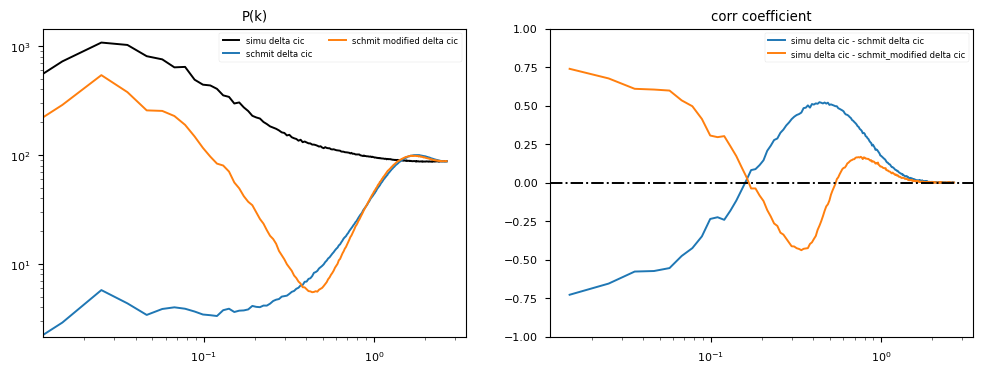

In [54]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, 2, facecolor="white", dpi=100, figsize=(12,4))
    ax[0].plot(Pk_simu_delta_cic['k'], Pk_simu_delta_cic["power"].real, color='k', label="simu delta cic")
    ax[0].plot(Pk_schmit_delta_cic['k'], Pk_schmit_delta_cic["power"].real, PlotParams.colors["default"][0], label="schmit delta cic")
    ax[0].plot(Pk_schmit_modified_delta_cic['k'], Pk_schmit_modified_delta_cic["power"].real, PlotParams.colors["default"][1], label="schmit modified delta cic")

    # ax[0].plot(Pk_simu_delta_cic['k'], 1e7 * Pk_simu_delta_cic['k']**4, PlotParams.colors["default"][5], label="$k^4$", ls='-.')
    
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].legend(ncol = 2, fontsize=6)
    ax[0].set_title("P(k)")
    # ax[0].set_ylim(500, 3*1e4)
    
    ax[1].plot(Pk_simu_schmit_deltadelta_cic['k'], corr_simu_schmit_deltadelta_cic, PlotParams.colors["default"][0], label="simu delta cic - schmit delta cic")
    ax[1].plot(Pk_simu_schmit_modified_deltadelta_cic['k'], corr_simu_schmit_modified_deltadelta_cic, PlotParams.colors["default"][1], label="simu delta cic - schmit_modified delta cic")
    
    ax[1].axhline(0, color='k', ls='-.')
    ax[1].set_ylim(-1, 1)
    ax[1].set_xscale("log")
    ax[1].legend(fontsize=6)
    ax[1].set_title("corr coefficient")

### 运行时间与内存占用测试

In [33]:
read.setPath(dirname="snapdir_000", filename="snapshot_000")
%lprun -f read.ReadGadget s = read.ReadGadget(type="snapshot", target=["pos", "id"], FlagPtype=np.array([False, True, False, False, False, False]), nFiles=-1, deBugFlag=False)

Timer unit: 1e-09 s

Total time: 41.8734 s
File: /home/zhanglf/GadgetReconstruction/displacement.py
Function: ReadGadget at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                               def ReadGadget(self, type, target, FlagPtype=np.array([False, True, False, False, False, False]), deBugFlag=True, nFiles=-1):
    18         1     207324.0 207324.0      0.0          totalLen = len(os.listdir(self.dirpath))
    19         1        451.0    451.0      0.0          nFiles = totalLen if nFiles < 0 else nFiles
    20         1        311.0    311.0      0.0          s = {}
    21         1        233.0    233.0      0.0          start = 0
    22         1        111.0    111.0      0.0          length = 0
    23                                           
    24        16       9504.0    594.0      0.0          for fid in range(nFiles):
    25        16       5618.0    351.1      0.0              if totalLen == 1:
    26         

In [37]:
read.setPath(dirname="groups_000", filename="fof_subhalo_tab_000")
%lprun -f read.ReadGadget g = read.ReadGadget(type="groups", target=["GroupLen", "GroupPos", "GroupMass", "GroupID"], nFiles=-1, deBugFlag=False)

Timer unit: 1e-09 s

Total time: 0.0476201 s
File: /home/zhanglf/GadgetReconstruction/displacement.py
Function: ReadGadget at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                               def ReadGadget(self, type, target, FlagPtype=np.array([False, True, False, False, False, False]), deBugFlag=True, nFiles=-1):
    18         1     229211.0 229211.0      0.5          totalLen = len(os.listdir(self.dirpath))
    19         1        421.0    421.0      0.0          nFiles = totalLen if nFiles < 0 else nFiles
    20         1        388.0    388.0      0.0          s = {}
    21         1        221.0    221.0      0.0          start = 0
    22         1        115.0    115.0      0.0          length = 0
    23                                           
    24        16       6371.0    398.2      0.0          for fid in range(nFiles):
    25        16       4385.0    274.1      0.0              if totalLen == 1:
    26       

In [38]:
%%mprun -f read.ReadGadget
read.setPath(dirname="snapdir_000", filename="snapshot_000")
s_0 = read.ReadGadget(type="snapshot", target=["pos", "id"], FlagPtype=np.array([False, True, False, False, False, False]), nFiles=-1, deBugFlag=False)

Filename: /home/zhanglf/GadgetReconstruction/displacement.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    17  23256.6 MiB  23256.6 MiB           1       def ReadGadget(self, type, target, FlagPtype=np.array([False, True, False, False, False, False]), deBugFlag=True, nFiles=-1):
    18  23256.6 MiB      0.0 MiB           1           totalLen = len(os.listdir(self.dirpath))
    19  23256.6 MiB      0.0 MiB           1           nFiles = totalLen if nFiles < 0 else nFiles
    20  23256.6 MiB      0.0 MiB           1           s = {}
    21  23256.6 MiB      0.0 MiB           1           start = 0
    22  23256.6 MiB      0.0 MiB           1           length = 0
    23                                         
    24  56024.7 MiB      0.0 MiB          17           for fid in range(nFiles):
    25  54245.8 MiB      0.0 MiB          16               if totalLen == 1:
    26                                                         filename = self.filename
    27           